## Background

Ames is city in Central Iowa, we are a team of data analysts working for Livable.io a company in the House-flipping business for residential properties.

Livable.io typically uses the following process for our home flip projects:

1) Purchase properties that are undervalued.
2) Peform renovations/repairs on the property to maximise value
3) Once repairs/renovations are completed relist the property at a higher selling price.

Profit is generated from price gains from the sale of relisted properties. To increase profit per relisting, Livable.io has decided to leverage on data analytics to better predict sale prices of our existing portfolio of properties and identify future opportunities.

## Problem Statement

**Problem statement:** Our team's goal is to build a linear regression model that can predict the expected sale price of a property to:

1) Use the predictions generatd by the model as a comparison against prices requested submitted by home sellers to determine if bids received are over/under valuation, 
2) determine how changes to various features of a house affects the sale price so that capital can be directed towards repairs/ renovations that generate the largest change in salesprice; and 
3) ascertain the expected sale price of a refurbised and relisted property.

Models will first be evaluated on the R^2 score to determined if the model is sufficiently generalised and able to explain variation in housing prices. Once the R^2 scores have been assessed, models will be ranked based on the RMSLE produced by the models when used to predict the prices of a secondary data set.

## Quick Links

1) [Background](#Background)
2) [Problem Statement](#Problem-Statement)
3) [Imports](#Imports)
4) [Data Cleaning](#Data-Cleaning) 
    - [Formatting](#Formatting)
    - [Missing Values](#Missing-values)
    - [Correcting Data types](#Correcting-Data-types)
    - [Encode Ordinal features to a numeric scale](#Encode-Ordinal-features-to-a-numeric-scale)
    
5) [EDA](#Exploratory-Data-Analysis)
    - [Relationship between numerical features and saleprice](#Relationship-between-numerical-features-and-saleprice)
    - [Relationship between ordinal features and saleprice](#Relationship-between-ordinal-features-and-saleprice)
    - [Relationship between categorical features and saleprice](#Relationship-between-categorical-features-and-saleprice)
    - [Distribution of features and target](#Distribution-of-features)
 
6) [Preprocessing](#Preprocessing)
   - [Looking for Outliers](#Looking-for-Outliers)
   - [Feature Engineering](#Feature-Engineering)
   - [Log transforming skewed features](#Log-transforming-skewed-features)
   - [Creating polynomial columns](#Creating-polynomial-columns)
   - [Scaling](#Scaling)
   - [Coverting categorical data to numerical via get dummies](#Coverting-categorical-data-to-numerical-via-get-dummies)
7) [Modelling](#Modelling)
    - [Baseline Model](#Baseline-model)
    - [Linear Regression](#Linear-Regression)
    - [Ridge Regression](#Ridge-Regression)
        - [Hyperparameter tuning for Ridge model](#Hyperparameter-tuning-for-Ridge-model)
    - [Lasso Regression](#Lasso-Regression)
        - [Hyperparameter tuning for Lasso model](#Hyperparameter-tuning-for-Ridge-model)
    - [ElasticNet](#ElasticNet)
        - [Hyperparameter tuning for Enet model](#Hyperparameter-tuning-for-Enet-model)
        - [Regression Coefficients](#Highlighted-and-interpreting-coefficients-of-features-selected-by-ElasticNet-Model)
8) [Conclusions and Recommendations](#Conclusions-and-Recommendations)

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE, SelectKBest, f_regression, chi2
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from scipy.stats import gaussian_kde
import scipy.stats as stats
from scipy.stats import skew, norm
import os
import random
import statsmodels.api as sm
import statsmodels.stats.multicomp
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, PolynomialFeatures, StandardScaler, RobustScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
import missingno as msno
pd.options.display.max_rows = 100
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
plt.style.use('bmh')

In [2]:
# import train data
train = pd.read_csv('../datasets/train.csv', index_col = 'Id')
test = pd.read_csv('../datasets/test.csv', index_col = 'Id')

## Data Cleaning

### Formatting

In [3]:
print(train.shape)
test.shape

(2051, 80)


(878, 79)

In [4]:
train.head()

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [5]:
test.head()

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
Id,,,,,,,,,,,,,,,,,,,,,
2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,AllPub,...,0,0,0,NaN,NaN,NaN,0,4,2006,WD
2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,AllPub,...,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,AllPub,...,0,0,0,NaN,NaN,NaN,0,9,2006,New
1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,AllPub,...,0,0,0,NaN,NaN,NaN,0,7,2007,WD
625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,AllPub,...,0,185,0,NaN,NaN,NaN,0,7,2009,WD



**HF:** Columns are in upper case and have spaces in them. For convinience we will strip the spaces and replace with underscore and make all characters to lower case for convinience.

train and test datasets have the same columns except for 'saleprice' which is suppose to be omitted in the test set.

In [6]:
#repling spaces with underscore and making all characters lower case
train.columns = [column.replace(" ",'_').lower() for column in train.columns]
test.columns = [column.replace(" ",'_').lower() for column in test.columns]

### Missing values

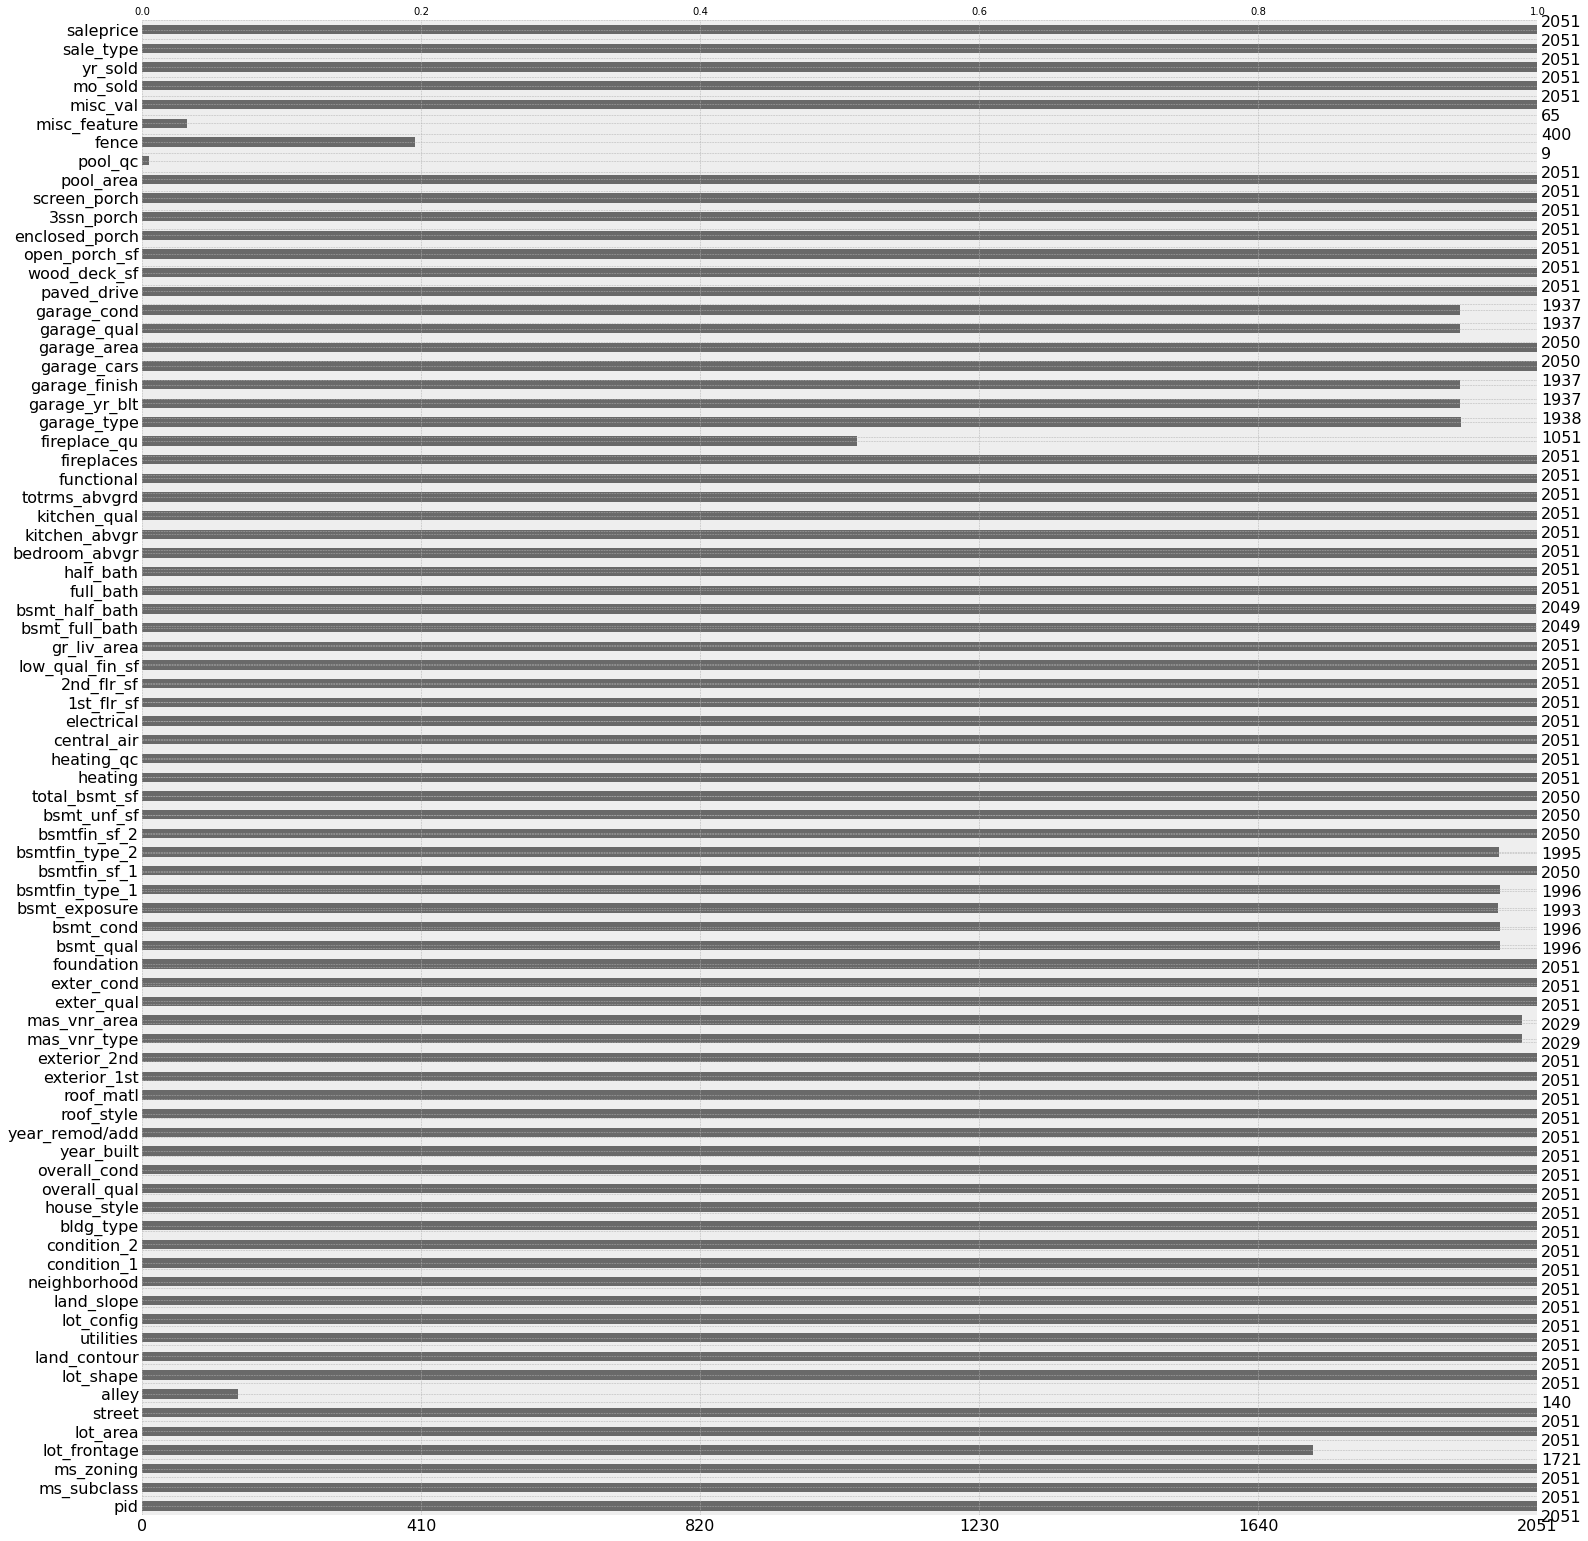

In [7]:
#bar chart for missing values
msno.bar(train);

**HF**: There appear to be quite a few features with missing values. In addition, several values (e.g. alley, misc value, etc.) are majority NANs. We'll have to come up with a few strategies to fill in the missing values. To start we will create a function to highlight the features with missing values.

In [8]:
#finding columns with nulls
def null_features(dataset):
    features_with_nulls = []
    for column in dataset.columns:
        if dataset[column].isnull().sum() != 0:
            features_with_nulls.append(column)
    print(features_with_nulls)
    

null_features(train)
null_features(test)

['lot_frontage', 'alley', 'mas_vnr_type', 'mas_vnr_area', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_sf_1', 'bsmtfin_type_2', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf', 'bsmt_full_bath', 'bsmt_half_bath', 'fireplace_qu', 'garage_type', 'garage_yr_blt', 'garage_finish', 'garage_cars', 'garage_area', 'garage_qual', 'garage_cond', 'pool_qc', 'fence', 'misc_feature']
['lot_frontage', 'alley', 'mas_vnr_type', 'mas_vnr_area', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_type_2', 'electrical', 'fireplace_qu', 'garage_type', 'garage_yr_blt', 'garage_finish', 'garage_qual', 'garage_cond', 'pool_qc', 'fence', 'misc_feature']


**HF:** There are 26 features with null values. We'll apply a different approach to fill in the null values for each group of features with missing values:

*Group 1:* These are categorical variables where missing values indicate that the property does not have the feature.

- alley, bsmt_cond, bsmt_exposure, bsmt_qual, bsmtfin_type_1, bsmtfin_type_2, fence, fireplace_qu, garage_cond, garage_finish, garage_qual, garage_type, misc_feature, pool_qc and mas_vnr_type


For this group we will replace all NAs with 'NONE' or 0 since the NAs are due to the property lacking the feature. 

*Group 2:* Are variables that are related to group 1 features, for this group will fill nulls with 0 for numerical features or none for categorical features.(eg. if bsmt_cond is NA bsmt_fin_sf_1 will be replaced as well)

In [9]:
grp_1_nas = ['alley', 'bsmt_cond', 'bsmt_exposure', 'bsmt_qual','bsmtfin_type_1','bsmtfin_type_2', 'fence', 'fireplace_qu', 'garage_cond','garage_finish', 'garage_qual', 'garage_type', 'misc_feature','pool_qc', 'mas_vnr_type']


In [10]:
#Filling NAs for columns where NA means property does not have th feature except for 'garage year built' as inputing 0 wouldnt make sense.

def NA_filler(dataset):
    adjacent_features = []
    for item in grp_1_nas:
        for i in dataset.index.values:
            if pd.isnull(dataset[item][i]):
                if dataset[item].dtype == object:
                    dataset.loc[i,item] = 'None'
                else:
                    dataset.loc[i,item] = 0
                for column in dataset.columns:
                    if item[0:3] in column:
                        if pd.isnull(dataset[column][i]):
                            if dataset[column].dtype == object:
                                dataset.loc[i,column] = 'None'
                            elif 'yr_' in column:
                                dataset.loc[i,column] = dataset.loc[i,'year_built']
                            else:
                                dataset.loc[i,column] = 0
                            if column not in adjacent_features:
                                 adjacent_features.append(column)


In [11]:
NA_filler(train)
NA_filler(test)

In [12]:
def NA_count(dataset):
    count = 0
    group_3_null_features = []
    for column in dataset.columns:
        if dataset[column].isnull().sum() != 0:
            count +=1
            group_3_null_features.append(column)
    print(count)
    print(group_3_null_features)
 


NA_count(train)
NA_count(test)

1
['lot_frontage']
2
['lot_frontage', 'electrical']


**HF:** After filling in the Nulls for group 1 and group 2 features we are left with only 2 features with Null values: 

- lot_frontage for the training data; and 
- electrical  and  lot_frontage for the test data

To fill in data for lot_frontage we will use sklearn to fill in the data for the 330 entries based on the relation between lot_frontage and the other features. While for electrical we will fill it with the mode of the other datapoints since it is unlikely that a house has no electrical system at all.

In [13]:
#substantiating Interative Imputer
it_imp = IterativeImputer(estimator = LinearRegression(), random_state=42)
numerical = [column for column in train.columns if train[column].dtype != object]
test['saleprice'] = [0 for item in test['pid']]
#transforing data
it_imp_lot_train = it_imp.fit_transform(train[numerical])
it_imp_lot_test = it_imp.transform(test[numerical])

In [14]:
#converting array to a Dataframe
it_imp_lot_train = pd.DataFrame(it_imp_lot_train, columns = train[numerical].columns, index = train[numerical].index)
it_imp_lot_test = pd.DataFrame(it_imp_lot_test, columns = test[numerical].columns, index = test[numerical].index)

In [15]:
#filling data
train['lot_frontage'] = it_imp_lot_train['lot_frontage']
test['lot_frontage'] = it_imp_lot_test['lot_frontage']

**HF:** After filling in the NAs for lot frontage there is a 1 more null value under electrical on the test data.

In [16]:
#filling in electrical Null with the mode for the entire population (train + test)
electrical_mode = pd.concat([train, test])[['electrical']]
#electrical_mode = electrical_mode.mode()
electrical_mode = electrical_mode['electrical'].mode().item()
electrical_mode

'SBrkr'

**HF:** Since electricity access is fairly standard we will fill the sole NAN value with the population mode.

In [17]:
test['electrical'].fillna(value = electrical_mode, inplace = True)
test[['electrical']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 878 entries, 2658 to 1939
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   electrical  878 non-null    object
dtypes: object(1)
memory usage: 46.0+ KB


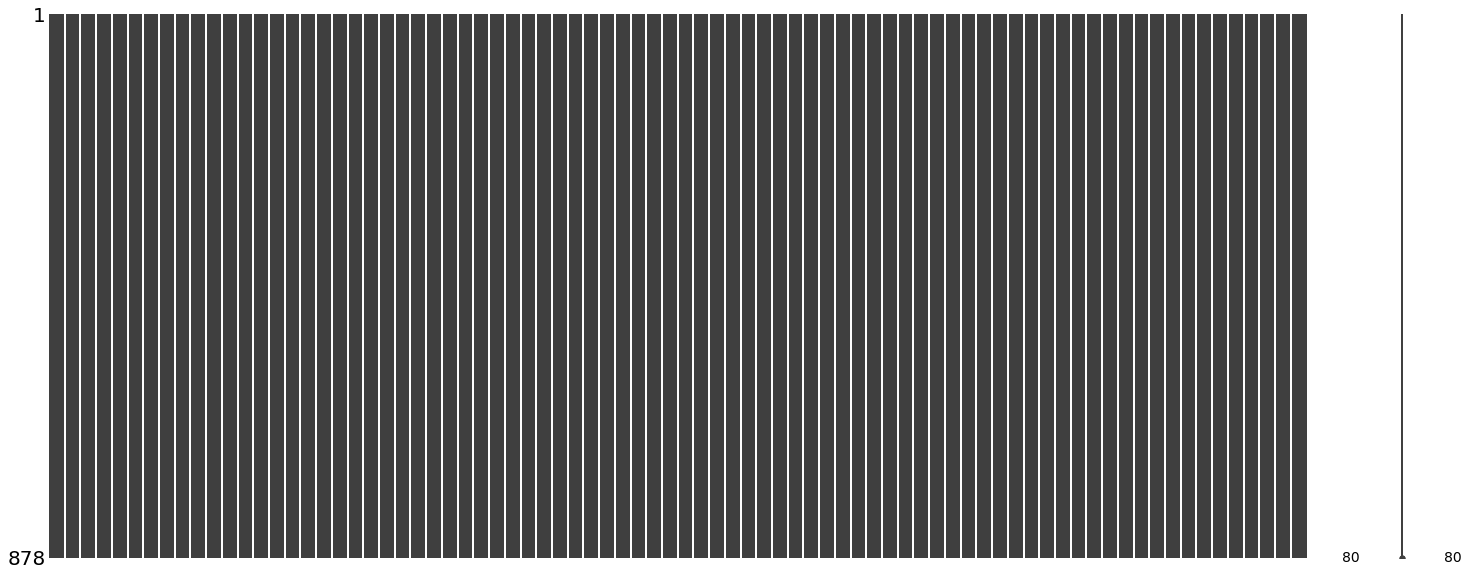

In [18]:
msno.matrix(test);

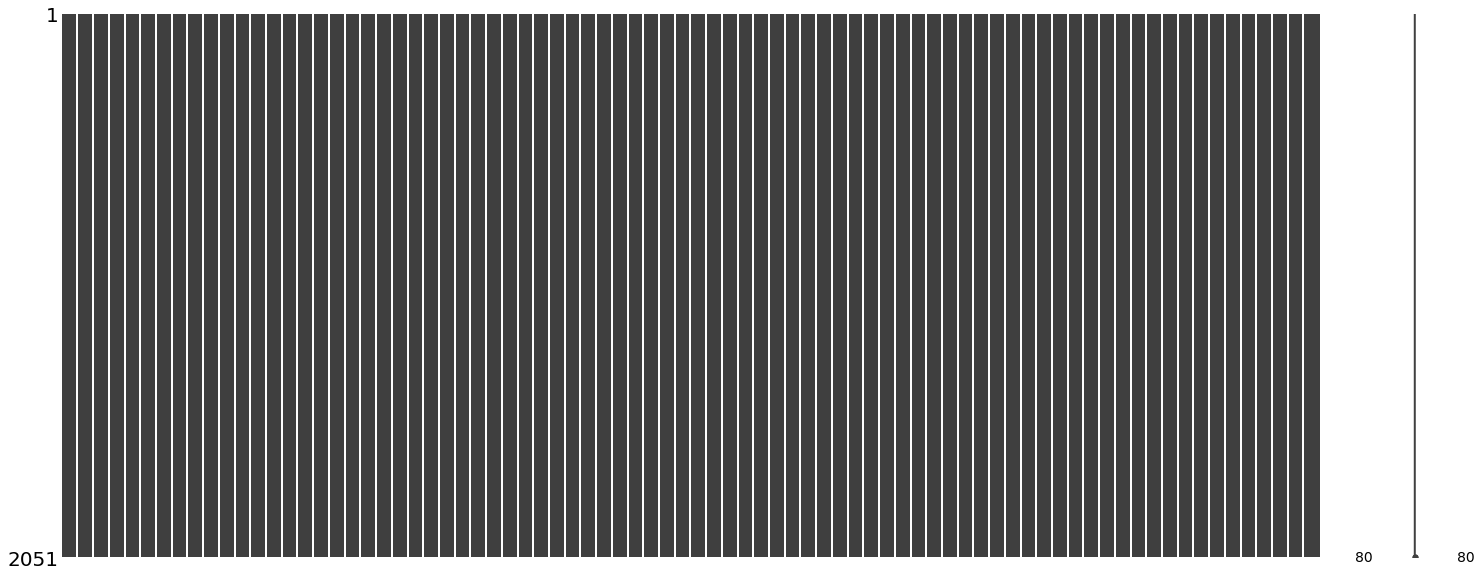

In [19]:
msno.matrix(train);

**HF:** There are now no missing values in the dataset.

### Correcting Data types

For the next part of the cleaning process we will be changing the dtypes for certain features so that they correctly describe the features.  

First we will be converting numerical features such as, ms_subclass into categorical data since the different values represent different types of dwelling and are not meant to be numerical.

In [20]:
#For ms_subclass we wil add a T infront of the inputs so that the datatype becomes object since,
#the different inputs signify a different type of subclass with no specfic order

train["ms_subclass"] = ['T{}'.format(ms_class) for ms_class in train["ms_subclass"]]
test["ms_subclass"] = ['T{}'.format(ms_class) for ms_class in test["ms_subclass"]]

In [21]:
# for month we will convert the various months from numerical to the mmm format equivalent

month_dict = {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun", 7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}


train.replace({'mo_sold': month_dict}, inplace = True)
test.replace({'mo_sold': month_dict}, inplace = True)

### Encode Ordinal features to a numeric scale

For ordinal features like 'bsmt_cond' that are ranked on a non-numerical scale we will convert them to a numerical scale. 

For example, 'bsmt_cond' is ranked as none, poor (Po), fair (Fa), average (TA), good (gd) and excellent (ex) we will conver this to a scale of 1 (none) - 6 (excellent).

In [22]:
# creating a list of ordinal features that are not ranked numerically.
ordinal_features = ['lot_shape', 'utilities', 'land_slope',  'exter_qual', 'exter_cond', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_type_2', 'heating_qc', 'electrical', 'kitchen_qual', 'functional', 'fireplace_qu', 'garage_finish', 'garage_qual', 'garage_cond', 'paved_drive', 'pool_qc', 'fence']

In [23]:
#identifying the unique variables for each feature in each dataset.
for feature in ordinal_features:
    print('unique values for feature: ({}) in train dataset are: {}'.format(feature, train[feature].unique()))
    print('unique values for feature: ({}) in test datasetare: {}'.format(feature, test[feature].unique()))
   

unique values for feature: (lot_shape) in train dataset are: ['IR1' 'Reg' 'IR2' 'IR3']
unique values for feature: (lot_shape) in test datasetare: ['Reg' 'IR1' 'IR3' 'IR2']
unique values for feature: (utilities) in train dataset are: ['AllPub' 'NoSeWa' 'NoSewr']
unique values for feature: (utilities) in test datasetare: ['AllPub' 'NoSewr']
unique values for feature: (land_slope) in train dataset are: ['Gtl' 'Sev' 'Mod']
unique values for feature: (land_slope) in test datasetare: ['Gtl' 'Mod' 'Sev']
unique values for feature: (exter_qual) in train dataset are: ['Gd' 'TA' 'Ex' 'Fa']
unique values for feature: (exter_qual) in test datasetare: ['TA' 'Gd' 'Fa' 'Ex']
unique values for feature: (exter_cond) in train dataset are: ['TA' 'Gd' 'Fa' 'Ex' 'Po']
unique values for feature: (exter_cond) in test datasetare: ['Fa' 'TA' 'Gd' 'Ex' 'Po']
unique values for feature: (bsmt_qual) in train dataset are: ['TA' 'Gd' 'Fa' 'None' 'Ex' 'Po']
unique values for feature: (bsmt_qual) in test datasetare: [

In [24]:
# creating a dictionary of variables for each feature for fitting using ordinal encoder
cats = {"category_1" : ['IR1', 'IR2' ,'IR3', 'Reg'], "category_2" : [ 'NoSewr',  'NoSeWa', 'AllPub'],
            "category_3" : ['Gtl' ,'Mod' ,'Sev'],"category_4" : ['None', 'Po', 'Fa', 'TA', 'Gd' ,'Ex'],
            "category_5" : ['None','No', 'Av', 'Mn','Gd' ],"category_6" : ['None',  'Unf', 'LwQ' ,'Rec','BLQ','ALQ', 'GLQ'],
            "category_7" : ['Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],"category_8" : ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
            "category_9" : ['None', 'Unf', 'RFn', 'Fin'],"category_10" : ['N', 'P', 'Y'],"category_11" : ['None', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']}
           

In [25]:
#creating a function for ordinal encoder
def ordinal_transformer(data_train = train, data_test = test):
    data_copy= pd.DataFrame(data_train, columns = data_train[ordinal_features].columns, index = data_train[ordinal_features].index)
    data_copy2= pd.DataFrame(data_test, columns = data_test[ordinal_features].columns, index = data_test[ordinal_features].index)
    for feature in ordinal_features:
        for category_n, category in cats.items():
            try:
                oc = OrdinalEncoder(categories = [category])
                oc.fit(data_copy[[feature]])
                data_copy[feature] = oc.transform(data_copy[[feature]])
                data_train[feature] = data_copy[feature]
                data_copy2[feature] = oc.transform(data_copy2[[feature]])
                data_test[feature] = data_copy2[feature]
            except:
                pass
   
        
ordinal_transformer()

In [26]:
test.head()

,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
Id,,,,,,,,,,,,,,,,,,,,,
2658,902301120,T190,RM,69.000000,9142,Pave,Grvl,3.0,Lvl,2.0,...,0,0,0.0,0.0,None,0,Apr,2006,WD,0
2718,905108090,T90,RL,87.894891,9662,Pave,None,0.0,Lvl,2.0,...,0,0,0.0,0.0,None,0,Aug,2006,WD,0
2414,528218130,T60,RL,58.000000,17104,Pave,None,0.0,Lvl,2.0,...,0,0,0.0,0.0,None,0,Sep,2006,New,0
1989,902207150,T30,RM,60.000000,8520,Pave,None,3.0,Lvl,2.0,...,0,0,0.0,0.0,None,0,Jul,2007,WD,0
625,535105100,T20,RL,84.873745,9500,Pave,None,0.0,Lvl,2.0,...,185,0,0.0,0.0,None,0,Jul,2009,WD,0


**HF:** Ordinal Features are now on a numerical scale

## Exploratory Data Analysis

To start the EDA we will first isolate the numerical features and identify the features that have the strongest correlations with sale price for a more in depth analysis.

### Identifying features tha correlate with target variable

In [27]:
#creating a list of numerical features that excludes features that are incorrectly labeled as int
numerical_columns = ['lot_frontage',
 'lot_area',
 'mas_vnr_area',
 'bsmtfin_sf_1',
 'bsmtfin_sf_2',
 'bsmt_unf_sf',
 'total_bsmt_sf',
 '1st_flr_sf',
 '2nd_flr_sf',
 'low_qual_fin_sf',
 'gr_liv_area',
 'bsmt_full_bath',
 'bsmt_half_bath',
 'full_bath',
 'half_bath',
 'bedroom_abvgr',
 'kitchen_abvgr',
 'totrms_abvgrd',
 'fireplaces',
 'garage_yr_blt',
 'garage_cars',
 'garage_area',
 'wood_deck_sf',
 'open_porch_sf',
 'enclosed_porch',
 '3ssn_porch',
 'screen_porch',
 'pool_area',
 'misc_val',
 'saleprice']

In [28]:
# calculating correlations and finding the top 10 numerical features.
corr = train[numerical_columns].corr()
high_cor_only = corr[abs(corr)>=0.5]

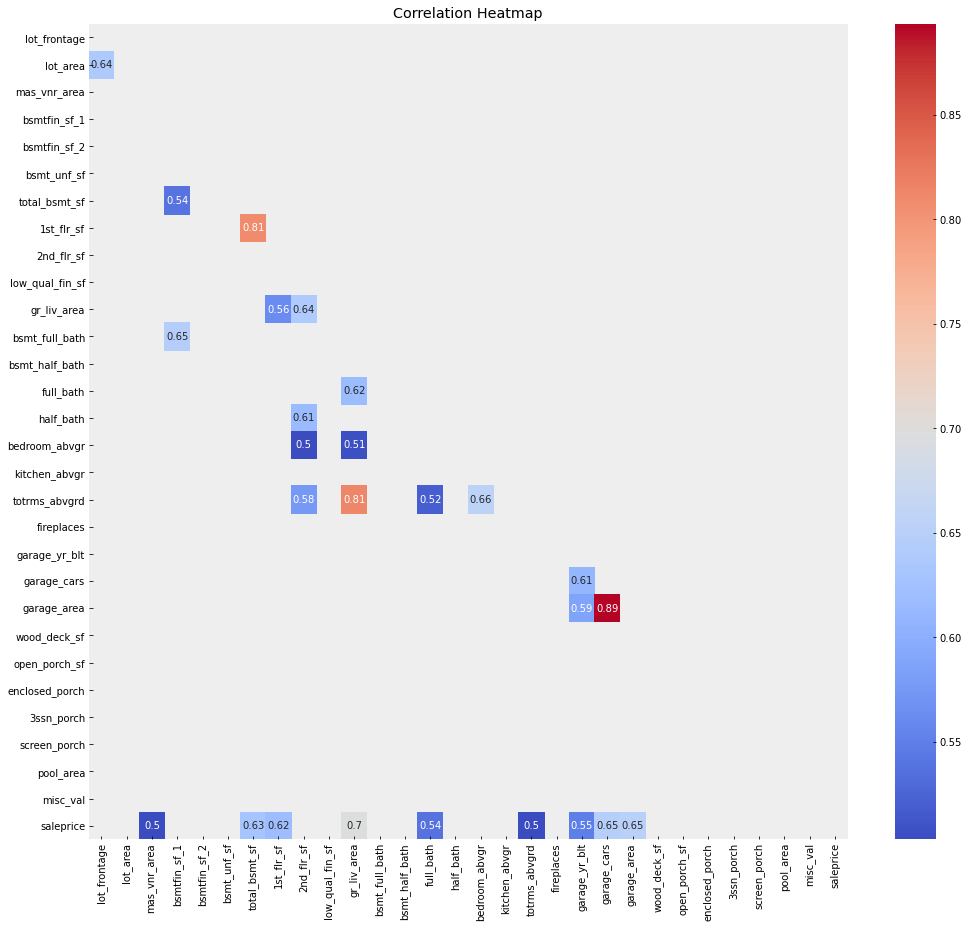

In [29]:
# Creating a Mask
mask = np.triu(np.ones_like(high_cor_only, dtype=bool))
# Heatmap of features
plt.figure(figsize= (17, 15))
sns.heatmap(high_cor_only, mask = mask, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap');

**HF:** sales price seems to be most strongly associated with gr_living_area, garage_cars/ garage_area, garage_yr_blt and bsmt_sf/ 1st_flr_sf. 

Broadly speaking these features are a measure of size or age with size positively correlated with saleprice and age negatively correlated with saleprice.

We can also see that several features are strongly correlated with each other, such as garage_area and garage_cars or 1st_flr -sf with total_bsmt_sf. To address this collinearity we can consider combinining some features with other related features to create new features (e.g. total_bsmt_sf with 1st_flr_sf) which might also have the benefit of producing features with stronger correlation with salesprice than the original features.

We will address this in the data engineering portion of this code book.

In [30]:
# calculating correlations and finding the top 10 ordinal features.
#creating a list of ordinal features + saleprice
ordinal_features.append('saleprice')
ordinal_features = ['lot_shape',
 'utilities',
 'land_slope',
 'exter_qual',
 'exter_cond',
 'bsmt_qual',
 'bsmt_cond',
 'bsmt_exposure',
 'bsmtfin_type_1',
 'bsmtfin_type_2',
 'heating_qc',
 'electrical',
 'kitchen_qual',
 'functional',
 'fireplace_qu',
 'garage_finish',
 'garage_qual',
 'garage_cond',
 'paved_drive',
 'pool_qc',
 'fence',
 'saleprice']

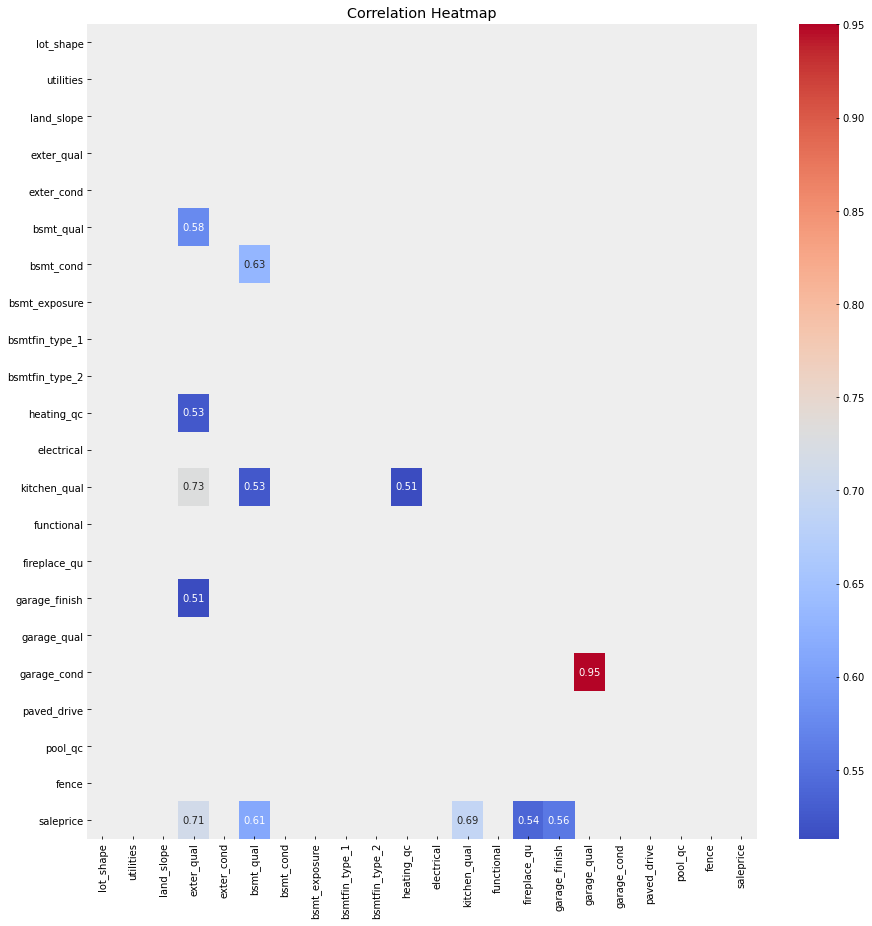

In [31]:
# calculating correlations and finding the top 10 ordinal features.
corr2 = train[ordinal_features].corr()

#creating a mask
high_cor_only2 = corr2[abs(corr2)>=0.5]
mask = np.triu(np.ones_like(high_cor_only2, dtype=bool))

#plotting heatmap
plt.figure(figsize= (15, 15))
sns.heatmap(high_cor_only2, mask = mask, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap');

**HF:** In the heatmap for ordinal features we can see a similar trend where saleprice is positively correlated with several features that have a level of collinearitiy with one another such as garge_cond with garage_qual. As previously mentioned we can combine these related features to generate new features. In addition, usign regression models such as Ridge or Lasso with built in regularisation can reduce collinerity without having to remove to feature entirely.


In [32]:
# setting up functions for plotting
def shortcut(a_title, a_xlabel, a_ylabel):
    plt.title('{}'.format(a_title))
    plt.xlabel('{}'.format(a_xlabel))
    plt.ylabel('{}'.format(a_ylabel))

    
def joint_plotter(x_var, y_var = train['saleprice']):
    plt.figure(figsize = (6,6))
    fig = sns.jointplot(x = train[x_var],
                  y = y_var,
                  kind = 'scatter')
    fig.set_axis_labels(x_var.replace("_", " ").title(),'Sale Price' )
    plt.suptitle('Plot of sale price against {}'.format(x_var.replace("_", " ").title()), x = 1)
    return fig


def dis_prob_plot (feature, dataset=train):
    
    f, ax = plt.subplots(1, 2, figsize=(15,10))
    
    ax[0] = sns.distplot(dataset[feature],  fit=norm,   ax = ax[0])
    ax[0].set_title("Distribution Plot of {}".format(feature))
    
    ax[1] = stats.probplot((dataset[feature]), plot = plt)

Next we will plot these features agains sale price to establish if there are any patterns/relationships that can be observed.

In [33]:
# Creating a list of features with the highest correlations with saleprice
highest_corrs_numerical = high_cor_only.saleprice.sort_values(ascending = False).index
highest_corrs_ordinal = high_cor_only2.saleprice.sort_values(ascending = False).index

#### Relationship between numerical features and saleprice

<Figure size 432x432 with 0 Axes>

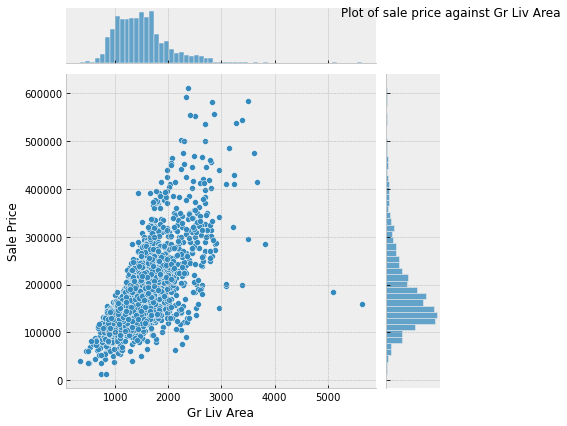

<Figure size 432x432 with 0 Axes>

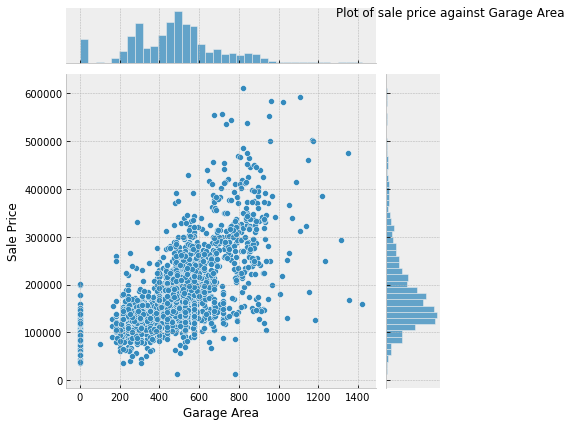

<Figure size 432x432 with 0 Axes>

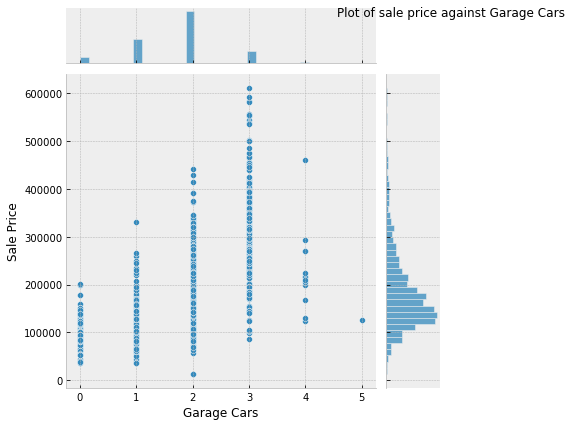

<Figure size 432x432 with 0 Axes>

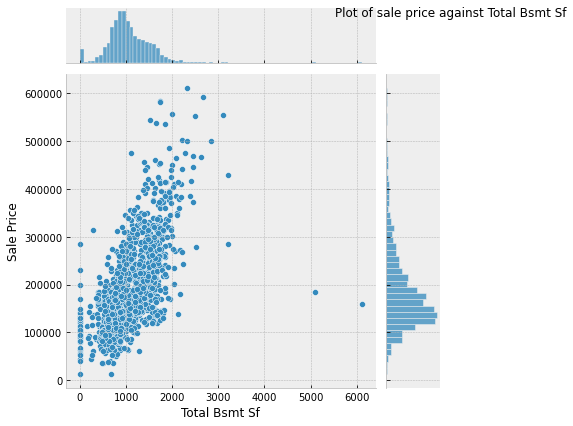

<Figure size 432x432 with 0 Axes>

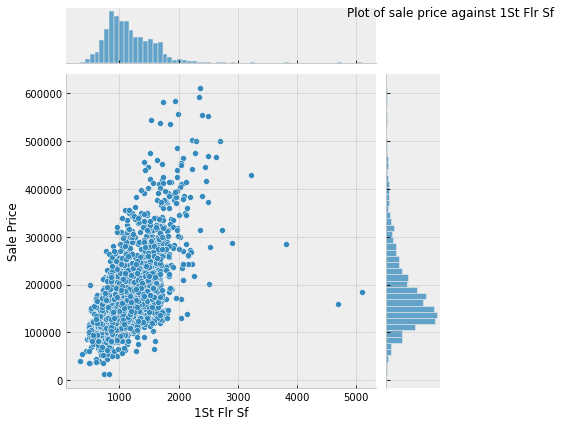

In [34]:
#plotting for features with high correlation with saleprice
for feature in highest_corrs_numerical[1:6]:
    joint_plotter(feature)

**HF:** It appears that sales price generally moves upwards as size of the house increases.

We also notice that there are 2 abnormally large houses with gr_liv_ares above 4000 sf that sold for notably low prices of ~$200,000. These 2 are likely outliers and should be removed from the dataset. A more in dept seach for outliers will be conducted in section 4 (preprocessing).

#### Relationship between ordinal features and saleprice

<Figure size 432x432 with 0 Axes>

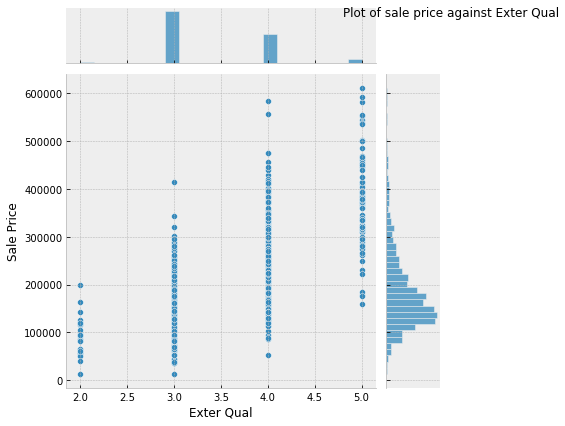

<Figure size 432x432 with 0 Axes>

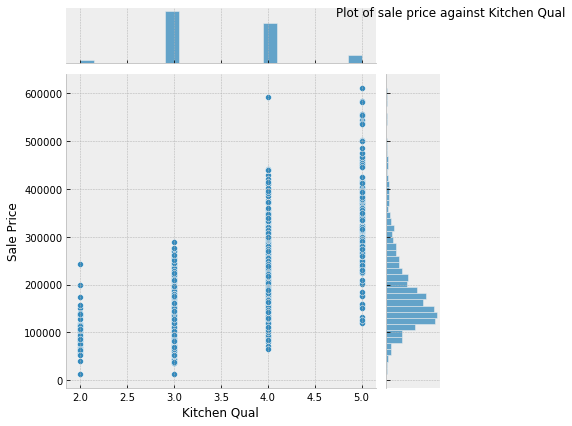

<Figure size 432x432 with 0 Axes>

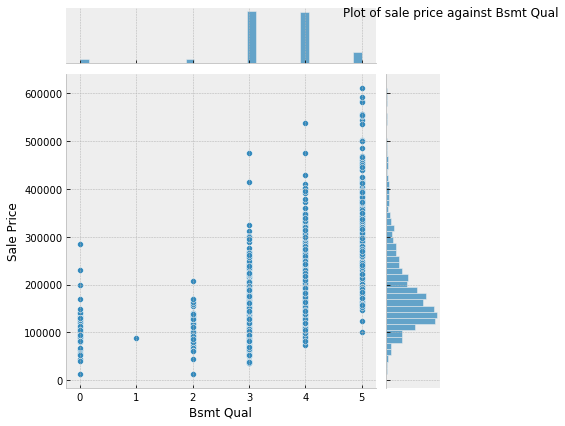

<Figure size 432x432 with 0 Axes>

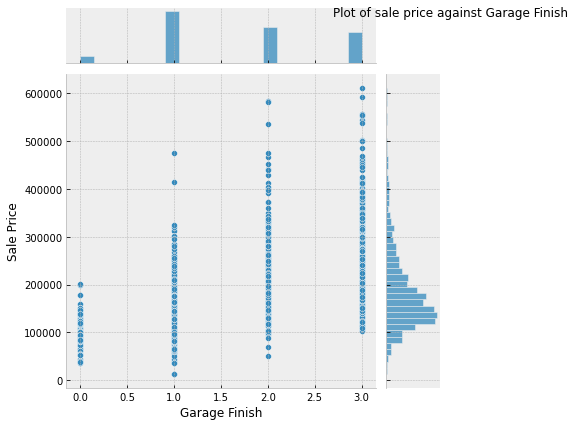

<Figure size 432x432 with 0 Axes>

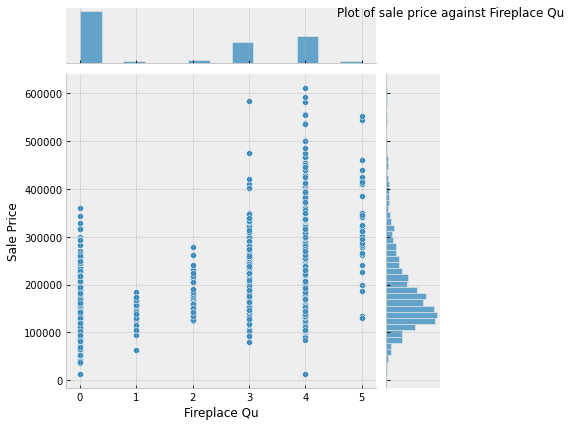

In [35]:
for feature in highest_corrs_ordinal[1:6]:
    joint_plotter(feature)

Looking at the charts we observe that sale price tends to be positively correlated with the quality of the house and  the quality of specific features like bsmt_qual. 

#### Relationship between Nominal features and saleprice

In [36]:
#creating a list of features not yet plotted
num_ord_combined = []
for feature in numerical_columns:
    num_ord_combined.append(feature)
    
for feature in ordinal_features:
    num_ord_combined.append(feature)

In [37]:
print(num_ord_combined)

['lot_frontage', 'lot_area', 'mas_vnr_area', 'bsmtfin_sf_1', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf', '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf', 'gr_liv_area', 'bsmt_full_bath', 'bsmt_half_bath', 'full_bath', 'half_bath', 'bedroom_abvgr', 'kitchen_abvgr', 'totrms_abvgrd', 'fireplaces', 'garage_yr_blt', 'garage_cars', 'garage_area', 'wood_deck_sf', 'open_porch_sf', 'enclosed_porch', '3ssn_porch', 'screen_porch', 'pool_area', 'misc_val', 'saleprice', 'lot_shape', 'utilities', 'land_slope', 'exter_qual', 'exter_cond', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_type_2', 'heating_qc', 'electrical', 'kitchen_qual', 'functional', 'fireplace_qu', 'garage_finish', 'garage_qual', 'garage_cond', 'paved_drive', 'pool_qc', 'fence', 'saleprice']


In [38]:
nominal_features = [feature for feature in train.columns if feature not in num_ord_combined]
print(nominal_features)

['pid', 'ms_subclass', 'ms_zoning', 'street', 'alley', 'land_contour', 'lot_config', 'neighborhood', 'condition_1', 'condition_2', 'bldg_type', 'house_style', 'overall_qual', 'overall_cond', 'year_built', 'year_remod/add', 'roof_style', 'roof_matl', 'exterior_1st', 'exterior_2nd', 'mas_vnr_type', 'foundation', 'heating', 'central_air', 'garage_type', 'misc_feature', 'mo_sold', 'yr_sold', 'sale_type']


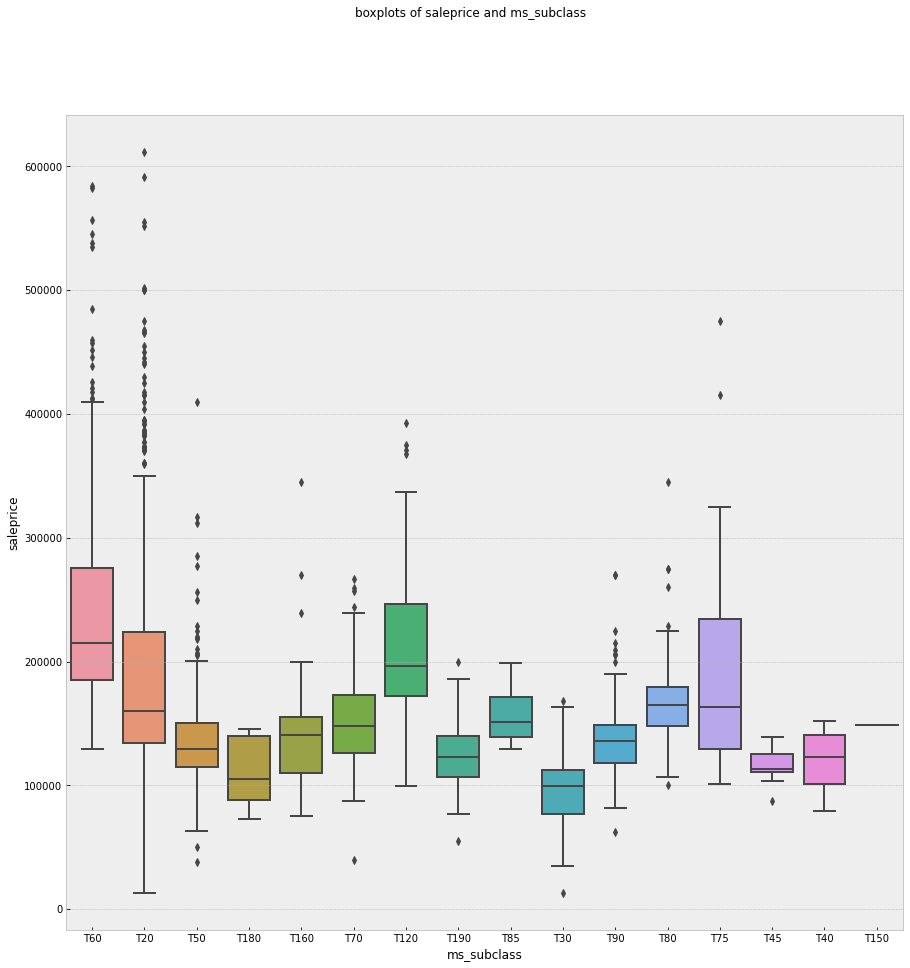

In [39]:
#plotting for selected featues
plt.figure(figsize= (15, 15))
sns.boxplot(x  = 'ms_subclass', y = 'saleprice', data = train)
plt.suptitle('boxplots of saleprice and ms_subclass');

**HF:** Looking at the boxplots for MS Subclass we can see 2flr houses (T60 and T70) tend to sell for highter than their 1flr counterparts (T20 and T30).


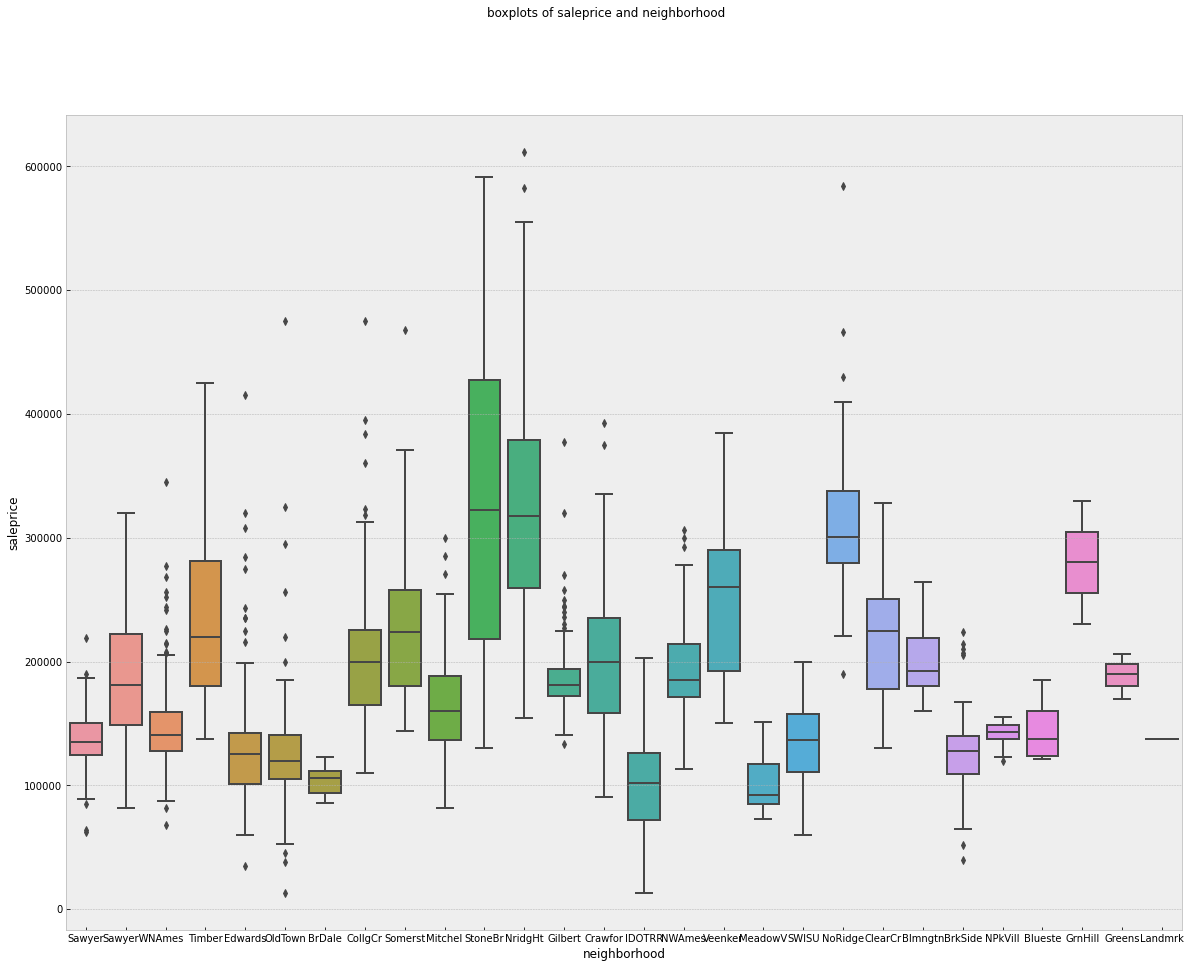

In [40]:
plt.figure(figsize= (20, 15))
sns.boxplot(x  = 'neighborhood', y = 'saleprice', data = train)
plt.suptitle('boxplots of saleprice and neighborhood');

**HF:** In the second chart we can see that neighborhood has an effect on saleprice with some neighborhoods like StoneBr have higher sale prices. 

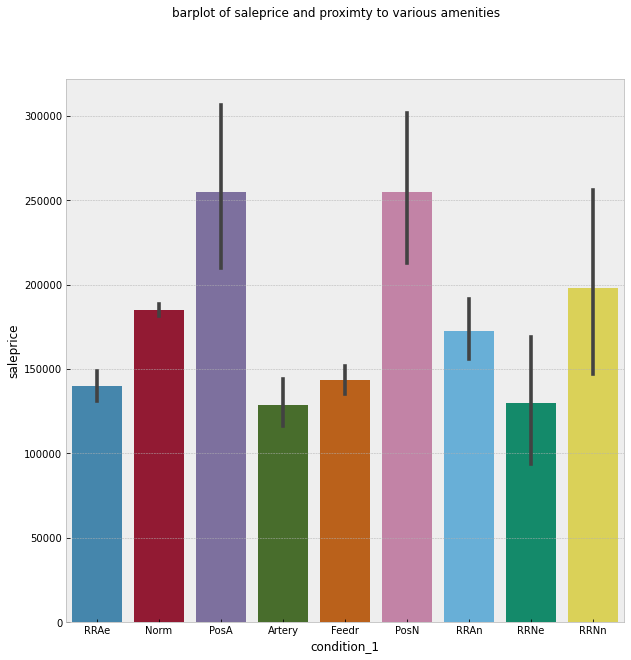

In [41]:
plt.figure(figsize= (10, 10))
sns.barplot(x = 'condition_1', y= 'saleprice', data = train)
plt.suptitle('barplot of saleprice and proximty to various amenities');

**HF:** Proximity to variious amenities/roads/transportation also appears to have an impact on sale prices as seen by houses near or adjacent to positive off-site amenities (PosN, PosA) or near the north-south railroads (RRNn)comanding higer prices than normal houses.

In summary, categorical features appear to have an affect on sale prices and we can dummify the variables to incorporate thse features into our regression.

### Distribution of features

#### Sale Price

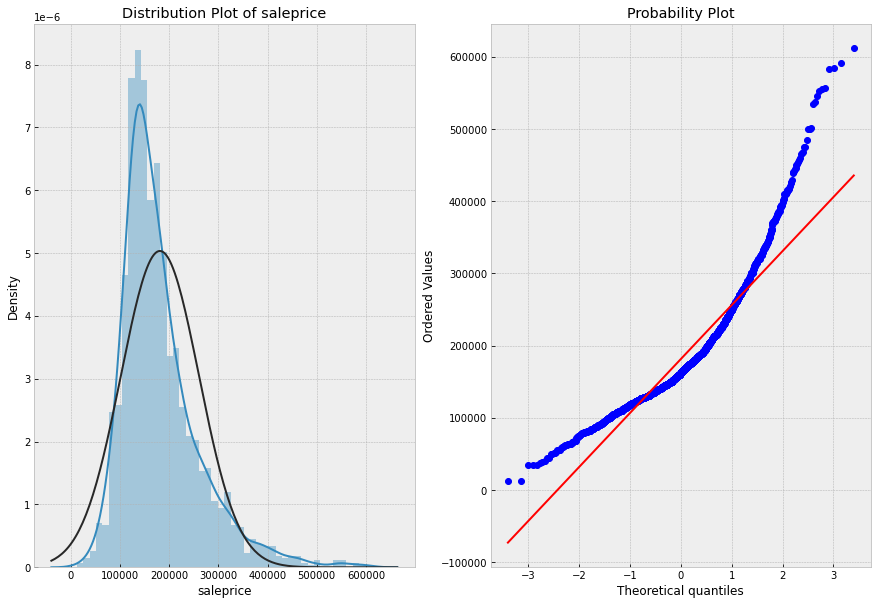

In [42]:
dis_prob_plot('saleprice')

**HF:** Distribution for sale price appears to be right skewed. In skewed data sets the tail regions tend to behave as outliers for the statistical model and can adversely affects the model's performance, log transformations to de-emphasize outliers and establish a more normal distributions should be performed.

#### Features

In addition to the saleprice we will also check the distributions of features that are either continuous or discrete. Nominal/ordinal features are not checked since they do not form normal distribution.

In [43]:
# creating a list of continuous or discrete columns
cont_discrete = ['lot_frontage',
 'lot_area',
 'mas_vnr_area',
 'bsmtfin_sf_1',
 'bsmtfin_sf_2',
 'bsmt_unf_sf',
 'total_bsmt_sf',
 '1st_flr_sf',
 '2nd_flr_sf',
 'low_qual_fin_sf',
 'gr_liv_area',
 'bsmt_full_bath',
 'bsmt_half_bath',
 'full_bath',
 'half_bath',
 'bedroom_abvgr',
 'kitchen_abvgr',
 'totrms_abvgrd',
 'fireplaces',
 'garage_yr_blt',
 'garage_cars',
 'garage_area',
 'wood_deck_sf',
 'open_porch_sf',
 'enclosed_porch',
 '3ssn_porch',
 'screen_porch',
 'pool_area',
 'misc_val',
 'saleprice']

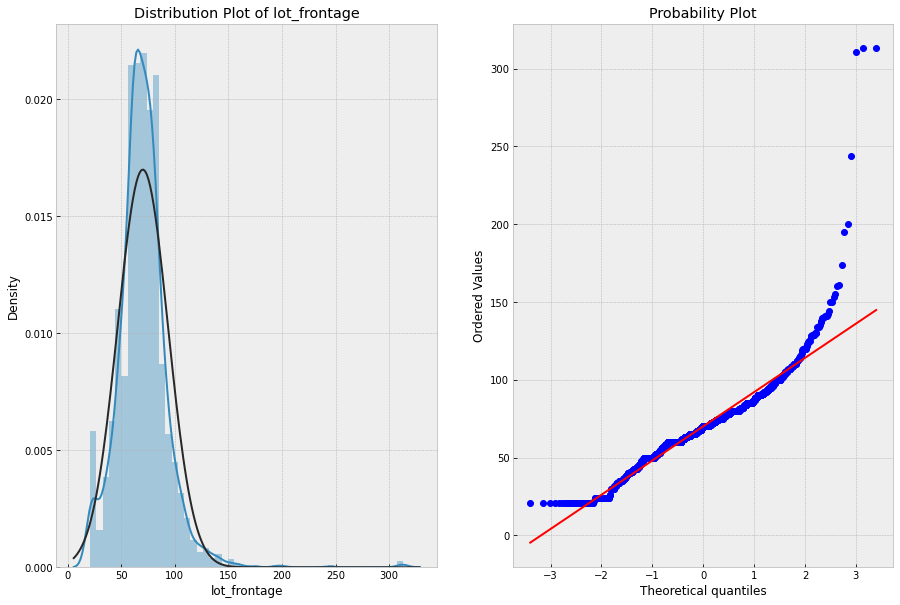

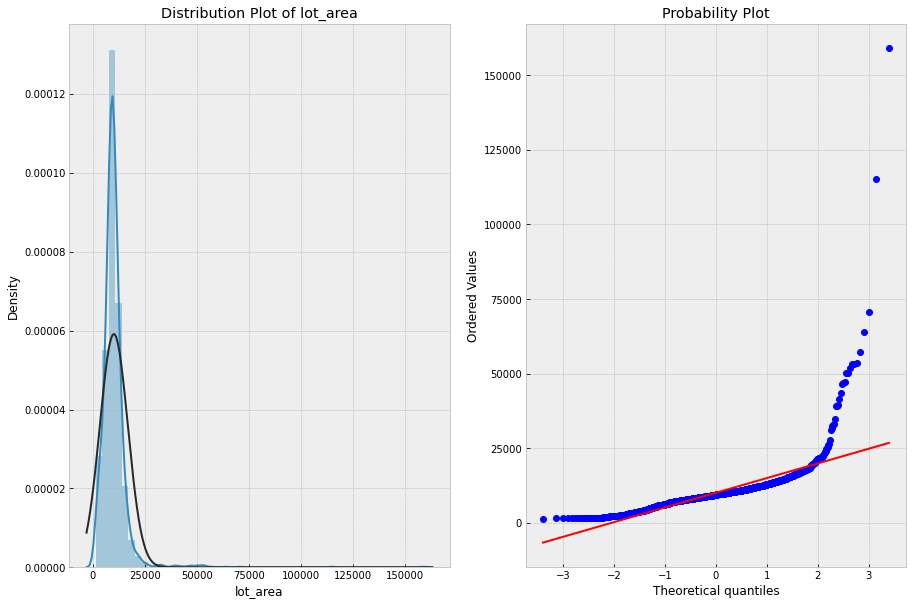

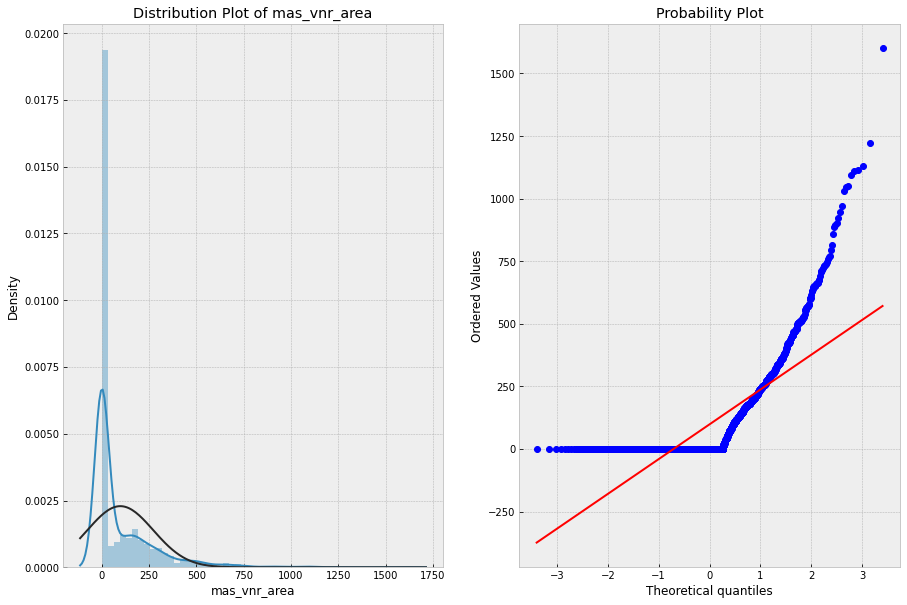

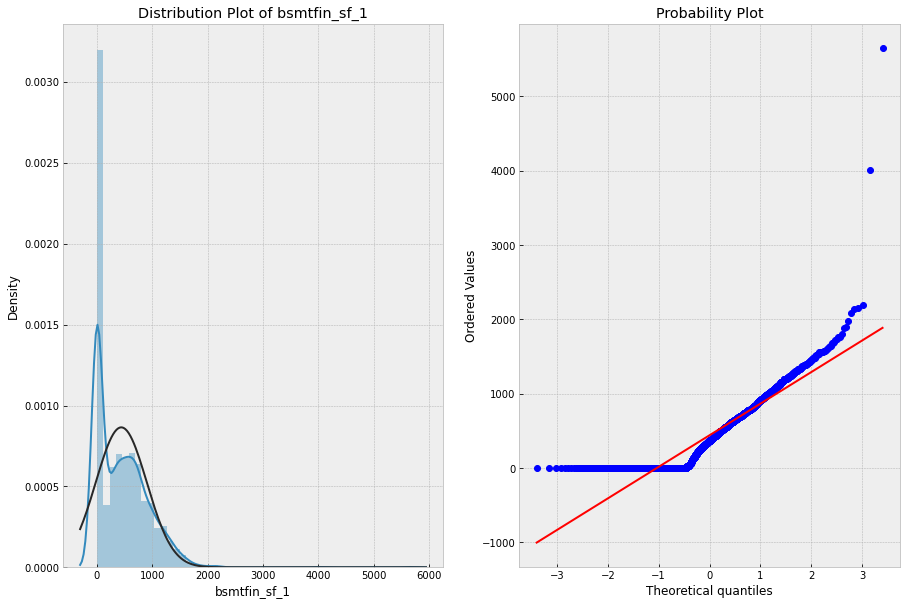

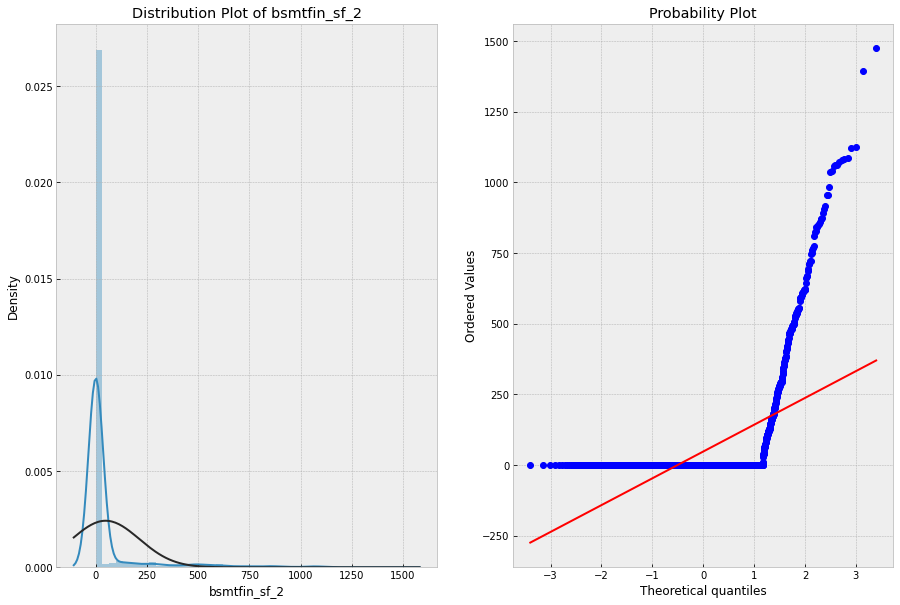

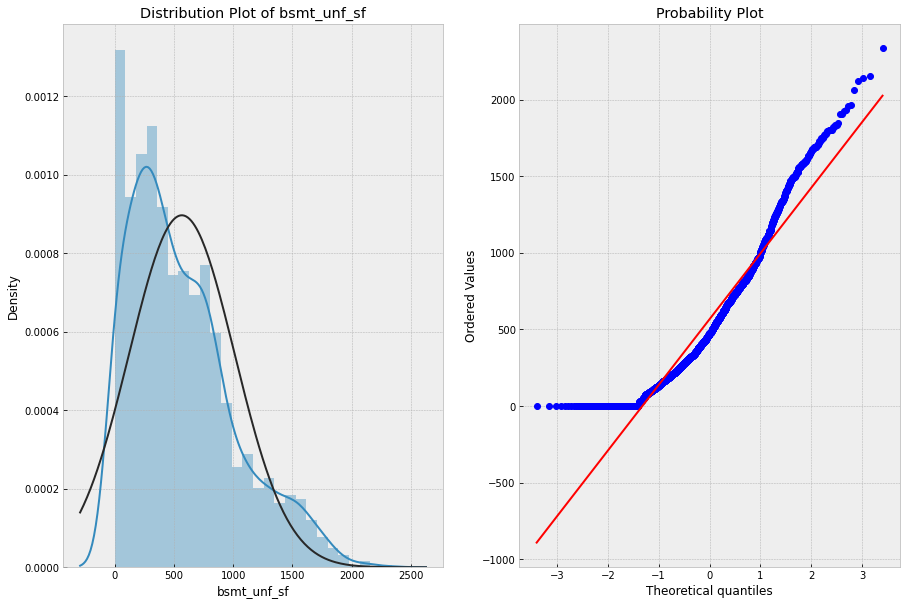

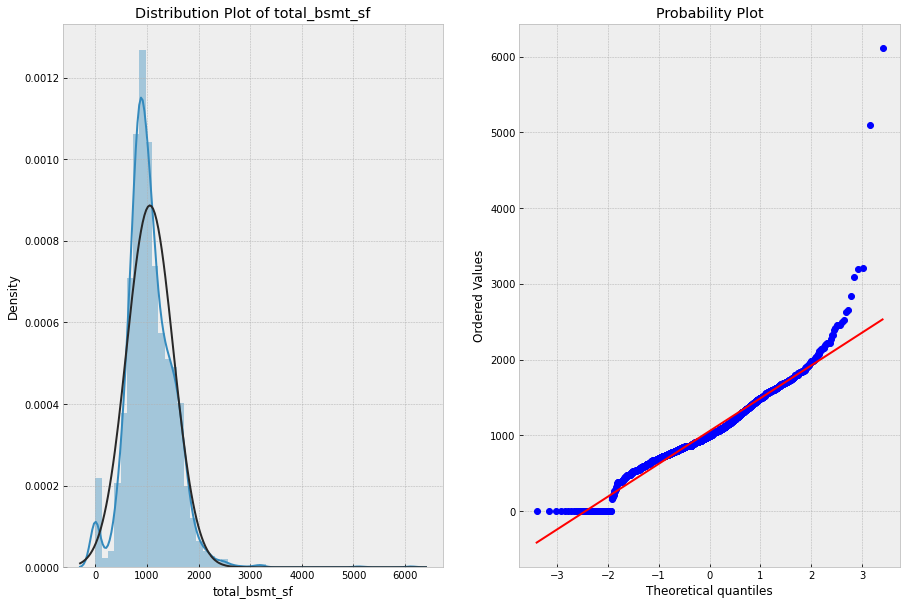

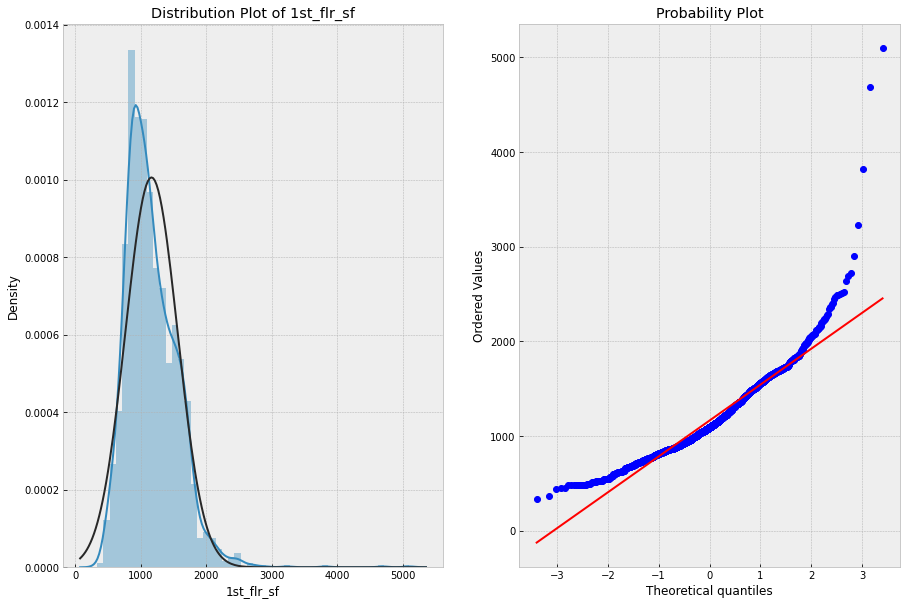

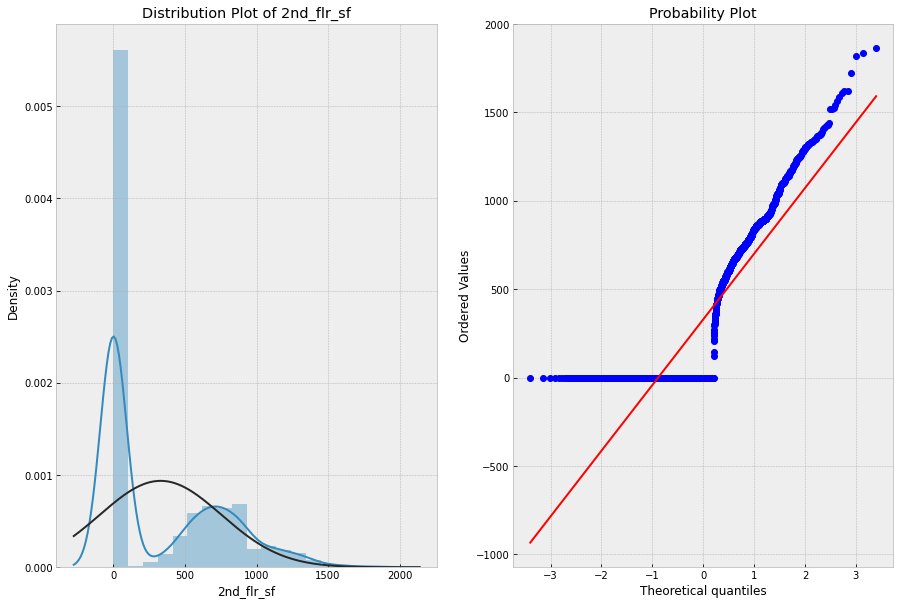

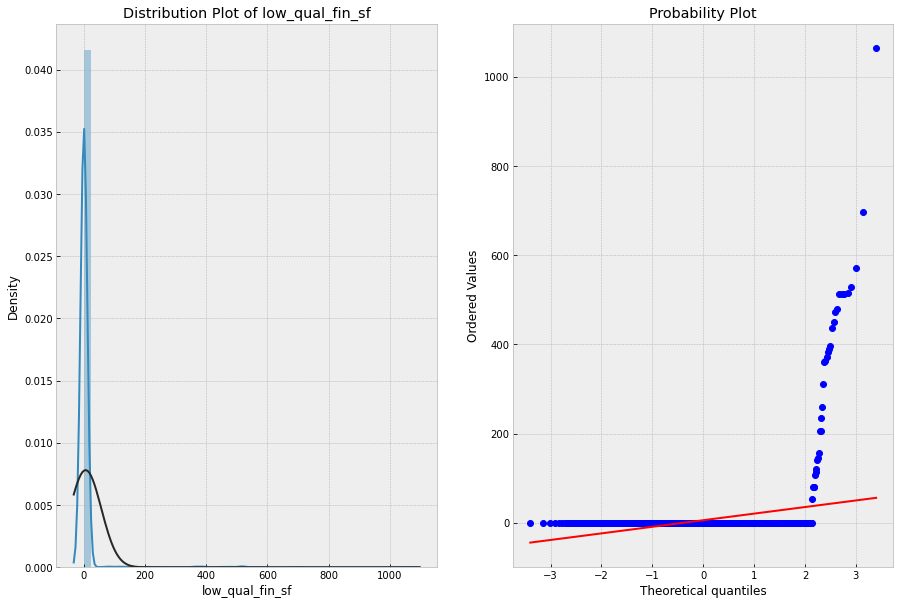

In [44]:
#plotting for 5 features
for item in cont_discrete[:10]:
    dis_prob_plot(item)

**HF:** Plotting the distributions of features we see that there are several features that are not normally distributed. Performing log transformation of these features should help to improve the accuracy of predictions. As part of the preprocessing stage we will create a function that identifies features that are not normally distributed and transform them.


## Preprocessing

##### Looking for Outliers

In the previous section while plotting the various features against sale price we identified several 2 possible outliers for gr_liv_area. In addition, there is likely an error in garage_year_blt where the year is recorded as 2207. It is likely that the dataset has other outliers/errors and we should employ different strategies to mitigate their impact.

1) Firstly for the 2 datapoints with gr_liv_area of above 4000 that only sold for ~200,000 we will remove them from the regression since they are clearly outliers and should be removed.

2) Next we can also see that there is 1 house with a garage that is built in 2207 this is an error and we will also remove this data point point.

3) lastly there are several features that have less noticably outliers and we will use a IQR to determine if they are indeed outliers before determining if the datapoints should be kept.


We will only be searching for outliers for continous / discrete features since the inputs for categorical and ordinal data act as  a natural floor/cap of acceptable inputs.

In [45]:
# removing outliers for gr_liv_area and garage_yr_blt
for i in [train[train['garage_yr_blt'] >= 2011].index]:
          print(i)
          train.drop(i, inplace = True)
            
for i in [train[train['gr_liv_area'] > 4000].index]:
    print(i)
    train.drop(i, inplace = True)

Int64Index([2261], dtype='int64', name='Id')
Int64Index([1499, 2181], dtype='int64', name='Id')


In [46]:
rows_with_outliers = []
features_with_outliers = []
def outlier_identifier(dataset):
    for feature in dataset[cont_discrete].columns:
        q1 = dataset[feature].quantile(0.05)
        q3 = dataset[feature].quantile(0.95)
        iqr = q3-q1
        for i in dataset.index.values:
            if dataset.loc[i,feature]> (q3 +1.5*iqr) or dataset.loc[i,feature]<(q1-1.5*iqr):
                if i in rows_with_outliers:
                    pass
                else:
                    rows_with_outliers.append(i)
                    if feature in features_with_outliers:
                        pass
                    else:
                        features_with_outliers.append(feature)
    print(len(rows_with_outliers))
    print(len(features_with_outliers))
    
    
outlier_identifier(train)

245
14


**HF:** After removing the datapoints for 1) and 2) above we can see that using the IQR to sieve out outliers there are about 245  posible outliers. Considering that it is about 10% of our train data we will keep these rows and instead minimise the impact of outliers by log transforming skewed values which should minimise their impact.

#### Feature Engineering

Next we will begin the process of feature engineering to create features that are better related to saleprice.

Generally features in this dataset tend to be a measure of various aspects of each part of the property, using a garage as an example: 
1) condition = garage_qual and garage_cond
2) size = garage_size or garage_cars
3) age = garage_yr_built
4) type of garage
5) misc properties: garage_finish

We can create additional features by grouping similar fucntions with one another based on the area of the property that they cover and the aspect that the feature is measuring. These additional features might have a stronger correlation with saleprice and improve the accuracy of the model.

In [47]:
# Creating a function to create the features:
def feature_changes(dataset):
    #overall state
    dataset['overall_state'] = dataset['overall_qual']*dataset['overall_cond']
    #overall size
    dataset['hse_sf'] = dataset['total_bsmt_sf'] + dataset['1st_flr_sf']+ dataset['2nd_flr_sf']
    #overall age using either year of remod or year built whichever is later
    updated_age = lambda x, y: max([[item for item in x],[item for item in y]])
    dataset['latest_remod'] = updated_age(dataset['year_built'], dataset['year_remod/add'])
    dataset['age_from_latest_remod'] = dataset['yr_sold'] - dataset['latest_remod']

    dataset['hse_age'] = dataset['yr_sold'] - dataset['year_built']

    #exterior state
    dataset['exter_state'] = dataset['exter_qual']*dataset['exter_cond']

    #bsmt state
    dataset['bsmt_state'] = dataset['bsmt_qual']*dataset['bsmt_cond']
    #bsmt fin area
    dataset['bsmt_fin_area'] = dataset['bsmtfin_sf_1'] + dataset['bsmtfin_sf_2']
    #bsmt fin qual
    dataset['bsmtfin_type_combined'] = dataset['bsmtfin_type_1']*dataset['bsmtfin_sf_1'] + dataset['bsmtfin_type_2']*dataset['bsmtfin_sf_2']
                 

    #baths
    dataset['total_baths'] = dataset['bsmt_full_bath'] + dataset['full_bath'] + 0.5*(dataset['bsmt_half_bath'] +dataset['half_bath'])

    #Kitchen
    dataset['kitchen'] = dataset['kitchen_abvgr'] * dataset['kitchen_qual']

    #fireplace
    dataset['fireplace'] = dataset['fireplaces'] * dataset['fireplace_qu']

    #Garage state
    dataset['garage_state'] = dataset['garage_qual']*dataset['garage_cond']*dataset['garage_finish']

    #garage age 
    dataset['garage_age'] = dataset['yr_sold'] - dataset['garage_yr_blt']
    
    #garage size
    #dataset['garage_area_cars'] = dataset['garage_area'] / dataset['garage_cars']
 
    #pool
    dataset['pool_state'] = dataset['pool_area'] * dataset['pool_qc']

In [48]:
feature_changes(train)
feature_changes(test)

In [49]:
train.corr().saleprice.sort_values(ascending = False).head(20)

saleprice         1.000000
hse_sf            0.829882
overall_qual      0.803336
gr_liv_area       0.719598
exter_qual        0.714895
kitchen_qual      0.694159
total_bsmt_sf     0.664912
garage_area       0.655215
garage_cars       0.648271
1st_flr_sf        0.648054
total_baths       0.632878
bsmt_qual         0.613160
bsmt_state        0.601240
exter_state       0.597984
year_built        0.572148
overall_state     0.566171
garage_state      0.559970
garage_finish     0.558576
garage_yr_blt     0.556405
year_remod/add    0.550614
Name: saleprice, dtype: float64

**HF:** Looking at the correlations between various features and saleprice, we can see that some of our engineered features, such as,hse_sf, exter_state or garage_state have a stronger correlation with saleprice than their original components.

In the heatmaps from section 5 we noticed that there were features with collinearity with other features, we won't be manually dropping any features, instead we will use regression models that incorporate regularisation methods like ridge or lass (or combining them via ElasticNet)

#### Log transforming skewed features

We previously identified that the target variable (saleprice) and some features were skewed. Since skewed data can affect the accuracy of the model it is recommended that we check all continous and discrete features for skew and log transform them if required.

In [50]:
# creating a list of discrete/continuous features for log transformation
cont_discrete = ['lot_frontage',
 'lot_area',
 'mas_vnr_area',
 'bsmtfin_sf_1',
 'bsmtfin_sf_2',
 'bsmt_unf_sf',
 'total_bsmt_sf',
 '1st_flr_sf',
 '2nd_flr_sf',
 'low_qual_fin_sf',
 'gr_liv_area',
 'bsmt_full_bath',
 'bsmt_half_bath',
 'full_bath',
 'half_bath',
 'bedroom_abvgr',
 'kitchen_abvgr',
 'totrms_abvgrd',
 'fireplaces',
 'garage_yr_blt',
 'garage_cars',
 'garage_area',
 'wood_deck_sf',
 'open_porch_sf',
 'enclosed_porch',
 '3ssn_porch',
 'screen_porch',
 'pool_area',
 'misc_val',
 'saleprice',
 'bsmt_fin_area',
 'hse_sf',
 'total_baths']

In [51]:
#finding skewed features and features with normal distributions
def tryskew (x):
    try:
        return skew(x)
    except:
        pass

skewness = train[cont_discrete].apply(lambda x:tryskew(x))

In [52]:
# identifying features that are skewed
skewness = skewness[abs(skewness)>0.5]
skewness = pd.DataFrame(data = skewness)
skewed_features = [item for item in skewness.index]
norm_features = [item for item in cont_discrete if item not in skewed_features]
print(norm_features)
skewed_features

['total_bsmt_sf', 'full_bath', 'bedroom_abvgr', 'garage_cars', 'garage_area', 'total_baths']


['lot_frontage',
 'lot_area',
 'mas_vnr_area',
 'bsmtfin_sf_1',
 'bsmtfin_sf_2',
 'bsmt_unf_sf',
 '1st_flr_sf',
 '2nd_flr_sf',
 'low_qual_fin_sf',
 'gr_liv_area',
 'bsmt_full_bath',
 'bsmt_half_bath',
 'half_bath',
 'kitchen_abvgr',
 'totrms_abvgrd',
 'fireplaces',
 'garage_yr_blt',
 'wood_deck_sf',
 'open_porch_sf',
 'enclosed_porch',
 '3ssn_porch',
 'screen_porch',
 'pool_area',
 'misc_val',
 'saleprice',
 'bsmt_fin_area',
 'hse_sf']

In [53]:
# function to log transform skewed functions
def skew_transform (dataset):
    dataset[skewed_features] = np.log1p(dataset[skewed_features])
    print('{} features log transformed'.format(skewness.shape[0]))

In [54]:
skew_transform(train)
skew_transform(test)

27 features log transformed
27 features log transformed


In [55]:
rows_with_outliers = []
features_with_outliers = []
def outlier_hunter(dataset):
    for feature in dataset[cont_discrete].columns:
        q1 = dataset[feature].quantile(0.05)
        q3 = dataset[feature].quantile(0.95)
        iqr = q3-q1
        for i in dataset.index.values:
            if dataset.loc[i,feature]> (q3 +1.5*iqr) or dataset.loc[i,feature]<(q1-1.5*iqr):
                if i in rows_with_outliers:
                    pass
                else:
                    rows_with_outliers.append(i)
                    if feature in features_with_outliers:
                        pass
                    else:
                        features_with_outliers.append(feature)
    print('there are {} rows with outliers'.format(len(rows_with_outliers)))
    print(features_with_outliers)
    
    
outlier_hunter(train)

there are 213 rows with outliers
['low_qual_fin_sf', 'full_bath', 'kitchen_abvgr', '3ssn_porch', 'pool_area', 'misc_val', 'hse_sf']


**HF:** After correcting skew, there are still 213 rows with outliers across 6 features:

['low_qual_fin_sf', 'full_bath', 'kitchen_abvgr', '3ssn_porch', 'pool_area', 'misc_val']

Considering that there are only a few samples with a pool, 3ssn porch, misc features or low quality finishing we will not perform further transformations for these features and the regression will be done based on the data on hand.

For full bath and kitchen abv gr since the spread is small between 0-4 for 'full_bath' and 0 - 3 for 'kitchen_abvgr' we will be doing the regression without further transformations to these features as well.

#### Creating polynomial columns

In [56]:
# identifying features with the highest correlations with saleprice that will undergo polynomial transformations

In [57]:
corr_SP = pd.DataFrame(data = train.corr().saleprice.sort_values(ascending = False).reset_index().head(11))
corr_SP.drop([0], inplace = True)
corr_SP_items = [item for item in corr_SP['index']]

corr_SP_items

['overall_qual',
 'hse_sf',
 'gr_liv_area',
 'exter_qual',
 'kitchen_qual',
 'garage_cars',
 'total_baths',
 'total_bsmt_sf',
 'garage_area',
 'bsmt_qual']

**HF:** For the creation of polynomial features we will limit the creation to just features that have the strongest correlation with sale price as creating polynomial features for all features would make the dataset too large.

In [58]:
def poly_creator(dataset = train, testset = test):
    df = pd.DataFrame(dataset, columns = dataset[corr_SP_items].columns, index = dataset[corr_SP_items].index)
    df2 = pd.DataFrame(testset, columns = testset[corr_SP_items].columns, index = testset[corr_SP_items].index)
    poly = PolynomialFeatures(include_bias = False, degree = 3)
    data_poly = poly.fit_transform(df)
    data_poly = pd.DataFrame(data_poly, columns = poly.get_feature_names(corr_SP_items), index = dataset[corr_SP_items].index)
    test_poly = poly.fit_transform(df2)
    test_poly = pd.DataFrame(test_poly, columns = poly.get_feature_names(corr_SP_items), index = testset[corr_SP_items].index)
    for feature in data_poly.columns:
        dataset[feature] = data_poly[feature]
    
    for feature in test_poly.columns:
        testset[feature] = test_poly[feature]   

In [59]:
poly_creator()

#### Scaling

In [60]:
#isolating numerical features and dropping the target variable + pid
numerical = [feature for feature in train.columns if train[feature].dtype != object]
numerical.remove('saleprice')
numerical.remove('pid')

#initiating the SS
scaler = StandardScaler()
train[numerical] = scaler.fit_transform(train[numerical])
test[numerical] = scaler.transform(test[numerical])

#### Coverting categorical data to numerical via get dummies

In [61]:
categorical = [column for column in train.columns if train[column].dtype == object]

In [62]:
train_dummies = pd.get_dummies(train, columns = categorical)
test_dummies = pd.get_dummies(test, columns = categorical)

print(train_dummies.shape)
print(test_dummies.shape)

(2048, 533)
(878, 524)


There are 9 extra columns in the train dataset after creating dummies. To find out the cause of the error whe will compare the features in the train set with those in the test set to identify any missing/extra features.

In [63]:
# identifying features in test_dummies but not in train_dummies
extra_features = [feature for feature in test_dummies.columns.unique() if feature not in  train_dummies.columns.unique()]
extra_features

['roof_matl_Metal',
 'roof_matl_Roll',
 'exterior_1st_PreCast',
 'exterior_2nd_Other',
 'exterior_2nd_PreCast',
 'mas_vnr_type_CBlock',
 'heating_Floor',
 'sale_type_VWD']

In [64]:
# Adding place holder rows into the train dataset so that columns for the features below will be created when categorical values are dummified
train.loc[3001, 'exterior_1st'] = 'PreCast'
train.loc[3002, 'exterior_2nd'] = 'Other'
train.loc[3003, 'exterior_2nd'] = 'PreCast'

train.loc[3004, 'heating'] = 'Floor'


train.loc[3006, 'mas_vnr_type'] = 'CBlock'
train.loc[3007, 'roof_matl'] = 'Metal'
train.loc[3008, 'roof_matl'] = 'Roll'

train.loc[3010, 'sale_type'] = 'VWD'



In [65]:
# identifying features in train_dummies but not in test_dummies
extra_features2 = [feature for feature in train_dummies.columns.unique() if feature not in  test_dummies.columns.unique()]
extra_features2

['ms_subclass_T150',
 'ms_zoning_A (agr)',
 'neighborhood_GrnHill',
 'neighborhood_Landmrk',
 'condition_2_Artery',
 'condition_2_PosN',
 'condition_2_RRAe',
 'condition_2_RRAn',
 'condition_2_RRNn',
 'roof_matl_Membran',
 'exterior_1st_CBlock',
 'exterior_1st_ImStucc',
 'exterior_1st_Stone',
 'exterior_2nd_Stone',
 'heating_OthW',
 'heating_Wall',
 'misc_feature_TenC']

In [66]:
# Adding place holder rows into the test dataset so that columns for the features below will be created when categorical values are dummified

test.loc[4001, 'condition_2'] = 'Artery'
test.loc[4002, 'condition_2'] = 'PosN'
test.loc[4003, 'condition_2'] = 'RRAe'
test.loc[4014, 'condition_2'] = 'RRAn'
test.loc[4004, 'condition_2'] = 'RRNn'
test.loc[4005, 'exterior_1st'] = 'CBlock'
test.loc[4006, 'exterior_1st'] = 'ImStucc'
test.loc[4007, 'exterior_1st'] = 'Stone'
test.loc[4008, 'exterior_2nd'] = 'Stone'
test.loc[4009, 'heating'] = 'Wall'
test.loc[4009, 'ms_subclass'] = 'T150'

test.loc[4011, 'ms_zoning'] = 'A (agr)'
test.loc[4012, 'neighborhood'] = 'GrnHill'
test.loc[4013, 'neighborhood'] = 'Landmrk'

test.loc[4014, 'heating'] = 'OthW'
test.loc[4014, 'roof_matl'] = 'Membran'
test.loc[4014, 'misc_feature'] = 'TenC'

In [67]:
train_dummies = pd.get_dummies(train, columns = categorical)
test_dummies = pd.get_dummies(test, columns = categorical)

print(train_dummies.shape)
print(test_dummies.shape)

(2056, 541)
(891, 541)


**HF:** The number of features after creating dummies is now identical. The placeholder rows can now be dropped.

In [68]:
#dropping the dummy rows
for i in range(3001, 3012):
    try:
        train_dummies.drop([i], inplace = True)
    except:
        pass

train = train_dummies
train.sort_index().tail()

,pid,lot_frontage,lot_area,lot_shape,utilities,land_slope,overall_qual,overall_cond,year_built,year_remod/add,...,sale_type_COD,sale_type_CWD,sale_type_Con,sale_type_ConLD,sale_type_ConLI,sale_type_ConLw,sale_type_New,sale_type_Oth,sale_type_VWD,sale_type_WD
Id,,,,,,,,,,,,,,,,,,,,,
2924,923250060.0,0.550598,1.350781,0.755036,0.029659,3.876281,-0.779235,-0.509572,0.177154,-0.340294,...,0,0,0,0,0,0,0,0,0,1
2926,923275080.0,-1.711353,-0.224241,-1.365138,0.029659,-0.215793,-0.075587,0.395548,0.409236,-0.007385,...,0,0,0,0,0,0,0,0,0,1
2927,923276100.0,-0.022621,0.002150,-1.365138,0.029659,3.876281,-0.779235,-0.509572,0.376081,-0.054943,...,0,0,0,0,0,0,0,0,0,1
2929,924100070.0,0.437808,0.241369,0.755036,0.029659,3.876281,-0.779235,-0.509572,0.077690,-0.435411,...,0,0,0,0,0,0,0,0,0,1
2930,924151050.0,0.320593,0.163088,0.755036,0.029659,3.876281,0.628061,-0.509572,0.707627,0.468201,...,0,0,0,0,0,0,0,0,0,1


In [69]:
for i in range(4001, 4015):
    try:
        test_dummies.drop([i], inplace = True)
    except:
        pass

test= test_dummies
test.sort_index().tail()

,pid,lot_frontage,lot_area,lot_shape,utilities,land_slope,overall_qual,overall_cond,year_built,year_remod/add,...,sale_type_COD,sale_type_CWD,sale_type_Con,sale_type_ConLD,sale_type_ConLI,sale_type_ConLw,sale_type_New,sale_type_Oth,sale_type_VWD,sale_type_WD
Id,,,,,,,,,,,,,,,,,,,,,
2919,923228210.0,-3.344748,-3.532064,0.755036,0.029659,-0.215793,-1.482883,-0.509572,-0.054928,-0.673204,...,0,0,0,0,0,0,0,0,0,1
2921,923228310.0,-3.344748,-3.098781,0.755036,0.029659,-0.215793,-1.482883,-0.509572,-0.054928,-0.673204,...,0,0,0,0,0,0,0,0,0,1
2922,923229110.0,-0.552482,0.709463,-1.365138,0.029659,-0.215793,-0.075587,-0.509572,0.143999,-0.387853,...,0,0,0,0,0,0,0,0,0,1
2925,923251180.0,2.603625,1.630229,0.755036,0.029659,-0.215793,-0.779235,1.300667,-0.386474,0.563318,...,0,0,0,0,0,0,0,0,0,1
2928,923400125.0,-0.200477,0.325956,0.755036,0.029659,-0.215793,-0.779235,-0.509572,0.674472,0.373084,...,0,0,0,0,0,0,0,0,0,1


In [70]:
#checking if there are any extra features left
error = [feature for feature in test_dummies.columns.unique() if feature not in train_dummies.columns.unique()]
print(error)
error = [feature for feature in train_dummies.columns.unique() if feature not in test_dummies.columns.unique()]
error

[]


[]

**HF:** No more differences in columns between the training and test datasets.

## Modelling

In [71]:
#setting up target variable and predictors
y = train['saleprice']
features = [column for column in train.columns if column != 'saleprice']
features.remove('pid')
X = train[features]

In [72]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

### Baseline model

In [73]:
#creating a simple baseline using mean
y_pred_base = y_test.mean()


In [74]:
y_pred_base = [y_pred_base]*len(y_test)

In [75]:
base_rmse = np.sqrt(mean_squared_error(y_test, y_pred_base)).mean()

In [76]:
base_r2 = r2_score(y_test, y_pred_base)

In [77]:
print('RMSE for base model is: {}'.format(base_rmse))
print('R2 for base model is: {}'.format(base_r2))

RMSE for base model is: 0.3976269352295196
R2 for base model is: 0.0


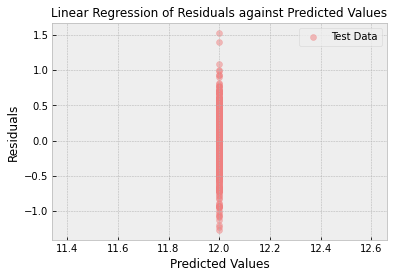

In [78]:
#plotting residuals against predictions

plt.scatter(x = y_pred_base,y = y_pred_base - y_test, label = 'Test Data', c = 'lightcoral', alpha = 0.5)
plt.title('Linear Regression of Residuals against Predicted Values', fontsize = 12)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend(loc = 'best')

plt.show()

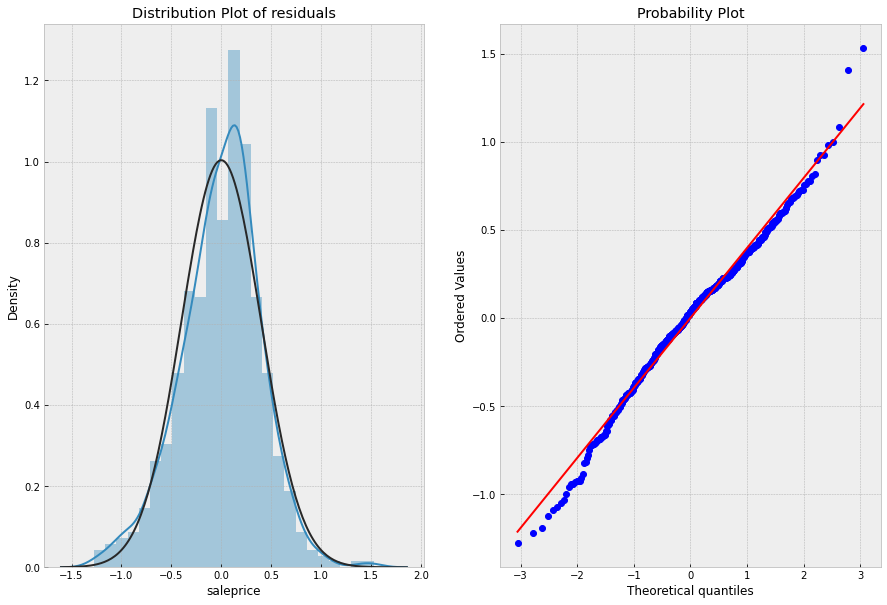

In [79]:
f, ax = plt.subplots(1, 2, figsize=(15,10))
    
ax[0] = sns.distplot(y_pred_base - y_test,  fit=norm,   ax = ax[0])
ax[0].set_title("Distribution Plot of {}".format('residuals'))
    
ax[1] = stats.probplot((y_pred_base-y_test), plot = plt)

**HF:** Base bodel does not predict results at all with a R2 score of zero, RMSLE is intrestingly lower than expected. We can see that residuals in the probability plot are all on a straight line and normally distributed.

#### Linear Regression

We will start our regression using a standard linear regression model

In [80]:
#instantiating LR model
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [81]:
# creating a cross val function for RMSE
rmse_scoring = make_scorer(mean_squared_error, greater_is_better = False)
def rmse_cv_train(model):
    rmse_score = np.sqrt(-cross_val_score(model, X_train, y_train, cv = 10, scoring = rmse_scoring, n_jobs = -1)).mean()
    return (rmse_score)

def rmse_cv_test(model):
    rmse_score = np.sqrt(-cross_val_score(model, X_test, y_test, cv = 10, scoring = rmse_scoring, n_jobs = -1)).mean()
    return (rmse_score)

#R2 scores
def r2_score_train(model):
    R2 = cross_val_score(model, X_train, y_train, cv = 10, n_jobs = -1).mean()
    return(R2)

def r2_score_test(model):
    R2 = cross_val_score(model, X_test, y_test, cv = 10, n_jobs = -1).mean()
    return(R2)

def dis_prob_plot_residuals_train(model):
    pred = model.predict(X_train)
    
    f, ax = plt.subplots(1, 2, figsize=(15,10))
    
    ax[0] = sns.distplot(pred - y_train,  fit=norm,   ax = ax[0])
    ax[0].set_title("Distribution Plot of {}".format('residuals'))
    
    ax[1] = stats.probplot((pred-y_train), plot = plt)
    
def dis_prob_plot_residuals_test(model):
    pred2 = model.predict(X_test)
    f, ax = plt.subplots(1, 2, figsize=(15,10))
    ax[0] = sns.distplot(pred2 - y_test,  fit=norm,   ax = ax[0])
    ax[0].set_title("Distribution Plot of {}".format('residuals'))
    
    ax[0] = stats.probplot((pred2-y_test), plot = plt)
    

In [82]:
print('RMSE on Training set: {}'.format(rmse_cv_train(lr)))
print('RMSE on Test set: {}'.format(rmse_cv_test(lr)))
print('R2 score on train is {}'.format(r2_score_train(lr)))
print('R2 score on test is {}'.format(r2_score_test(lr)))

RMSE on Training set: 0.23657243612643905
RMSE on Test set: 1.7310379606748938
R2 score on train is 0.6599656506143226
R2 score on test is -20.005654073490728


In [83]:
print('LR Picked {} features and eliminated {} features'.format(str(sum(lr.coef_!= 0)), str(sum(lr.coef_==0))))

LR Picked 538 features and eliminated 1 features


In [84]:
#creating a function to plot residuals and another to plot predictions
def residual_plotter(model):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    plt.scatter(x = y_train_pred,y = y_train_pred - y_train, label = 'Training Data', c = 'seagreen', alpha = 0.5, marker = 's')
    plt.scatter(x = y_test_pred,y = y_test_pred - y_test, label = 'Test Data', c = 'lightcoral', alpha = 0.5)
    plt.title('Linear Regression of Residuals against Predicted Values', fontsize = 12)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.legend(loc = 'best')
    plt.hlines(y = 0, xmin = y_test_pred.min(), xmax = y_test_pred.max(), color = "red", alpha = 0.3)
    plt.show()


#plotting predictions
    plt.scatter(y_train_pred, y_train, marker = 's', label = 'Training Data', c = 'seagreen', alpha = 0.5)
    plt.scatter(y_test_pred, y_test, label = 'Test Data', c = 'lightcoral', alpha = 0.5)
    plt.title('Linear regression of Real values against Predicted Values', fontsize = 12)
    plt.xlabel('Predicted Values')
    plt.ylabel('Real Values')
    plt.legend(loc = 'best')
    plt.plot([y_train_pred.min(), y_train_pred.max()], [y_train_pred.min(), y_train_pred.max()], c = "red", alpha = 0.3)
    plt.show();
    
#distribution of residuals
    f1 = sns.displot(x =y_train_pred - y_train)
    plt.suptitle('Distribution of Residuals (train)')
    
    #distribution of residuals
    f2=sns.displot(x =y_test_pred - y_test)
    plt.suptitle('Distribution of Residuals (test)')

    


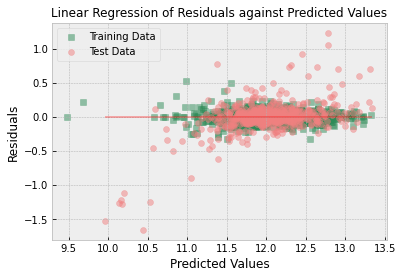

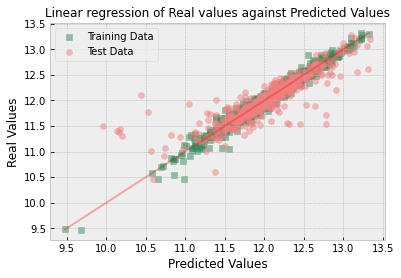

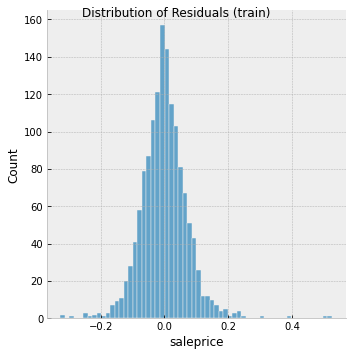

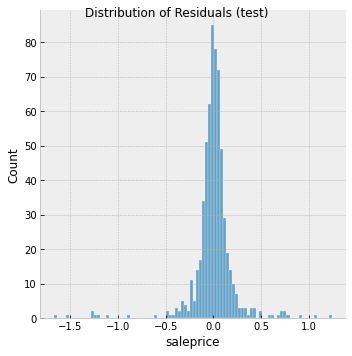

In [85]:
residual_plotter(lr)

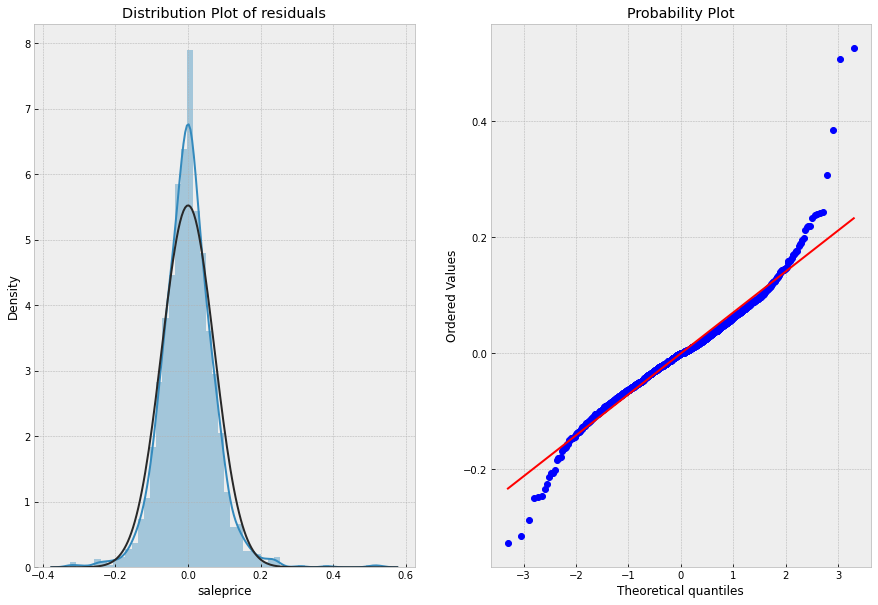

In [86]:
dis_prob_plot_residuals_train(lr)

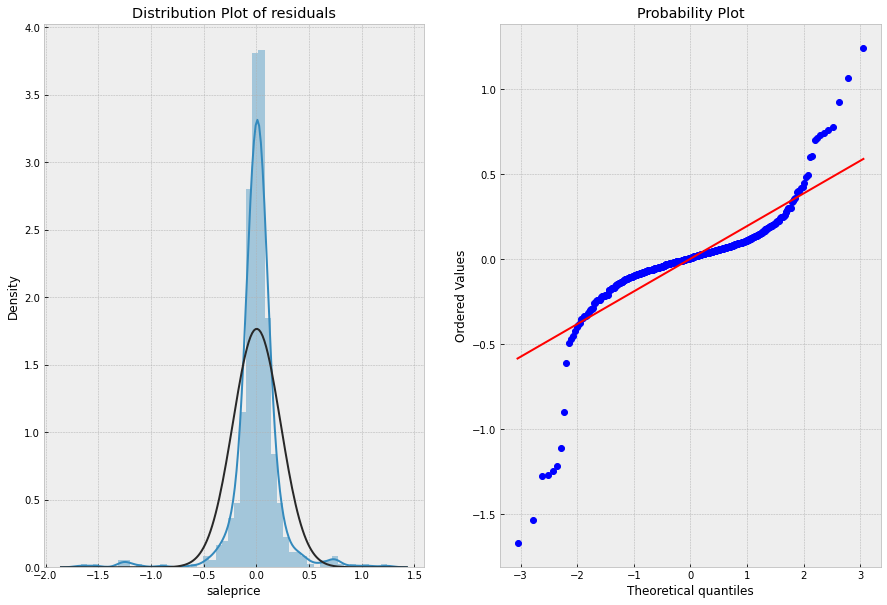

In [87]:
dis_prob_plot_residuals_test(lr)

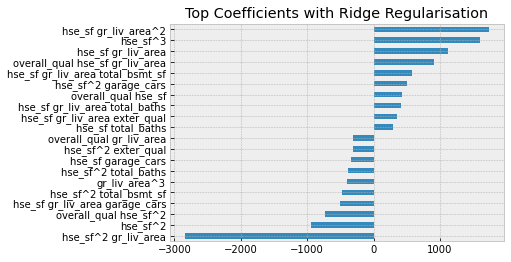

In [88]:
#Ploting the coeficients with the biggest impact on saleprice
lr_coefs = pd.Series(lr.coef_, index = X_train.columns)
imp_coefs = pd.concat([lr_coefs.sort_values().head(10), lr_coefs.sort_values().tail(10)])
imp_coefs.plot(kind = 'barh')
plt.title('Top Coefficients with Ridge Regularisation')
plt.show()

In [89]:
print('LR Picked {} features and eliminated {} features'.format(str(sum(lr_coefs!= 0)), str(sum(lr_coefs==0))))

LR Picked 538 features and eliminated 1 features


##### Observations on the Base LR model.

The base linear regression model looks like it performs decently with most residuals appearing mostly randomly distributed and scattered except for a few points with higher predicted values than expected.

Looking at the R^2 scores on the LR model is able to explain 65% of the variance on the training data. However, performance on the test data is significantly worse reporting a score of -20 indicating that the model does not follow the same trend as the data and cannot be used for prediction. As such, we will reject this model and develop additional regression models with regularisation.

When compared to the baseline model, the LR model performs even worse on the test with RMSLE of ~1.7, way above the baseline model's 0.39. R2 score for the LR model is similarly bad with a score of -20 compared to 0 for the baseline model.


Plotting residuals against predicted prices we can see that there a a positive relationship between predicted prices and residuals with residuals getting larger as predicted prices get larger.

On closer inspection of the histogram and probality plot of residuals for both the training and test data we see that the that the residuals has very large tails and indicates that the residuals are not normally distributed.

For regression coefficients, we can see that refression coefficients range between 2000 to -3000. Coefficients so large do not seem realistic and the model should be rejected.

### Ridge Regression

We previously highlighted that not all features were independent and there was some amount of collinearity between the various features. To mitigate this we will be incorporating different regularisation methods to mitigate the impact of collinearity.

In [90]:
# Setting up alphas for ridge model
ridge_alphas = np.linspace(20, 25, 100)
#setting up Ridge model
ridge = RidgeCV(alphas = ridge_alphas, cv = 10)
ridge.fit(X_train, y_train)

RidgeCV(alphas=array([20.        , 20.05050505, 20.1010101 , 20.15151515, 20.2020202 ,
       20.25252525, 20.3030303 , 20.35353535, 20.4040404 , 20.45454545,
       20.50505051, 20.55555556, 20.60606061, 20.65656566, 20.70707071,
       20.75757576, 20.80808081, 20.85858586, 20.90909091, 20.95959596,
       21.01010101, 21.06060606, 21.11111111, 21.16161616, 21.21212121,
       21.26262626, 21.31313131, 21.36363636, 21.4...
       23.53535354, 23.58585859, 23.63636364, 23.68686869, 23.73737374,
       23.78787879, 23.83838384, 23.88888889, 23.93939394, 23.98989899,
       24.04040404, 24.09090909, 24.14141414, 24.19191919, 24.24242424,
       24.29292929, 24.34343434, 24.39393939, 24.44444444, 24.49494949,
       24.54545455, 24.5959596 , 24.64646465, 24.6969697 , 24.74747475,
       24.7979798 , 24.84848485, 24.8989899 , 24.94949495, 25.        ]),
        cv=10)

In [91]:
#Cross val performance
print("Ridge RMSE on Training set :", rmse_cv_train(Ridge(alpha = ridge.alpha_)))
print("Ridge RMSE on Test set :", rmse_cv_test(Ridge(alpha = ridge.alpha_)))
print('R2 score on train is {}'.format(r2_score_train(Ridge(alpha = ridge.alpha_))))
print('R2 score on test is {}'.format(r2_score_test(Ridge(alpha = ridge.alpha_))))

Ridge RMSE on Training set : 0.1163239561956291
Ridge RMSE on Test set : 0.11552647964729379
R2 score on train is 0.9196811183230741
R2 score on test is 0.9113352641795854


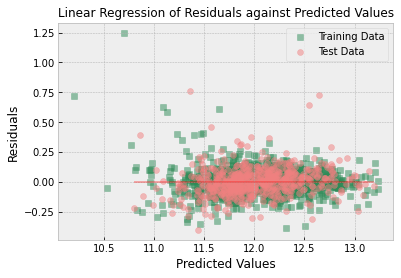

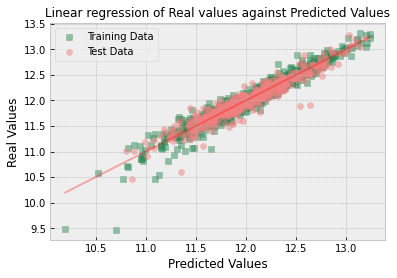

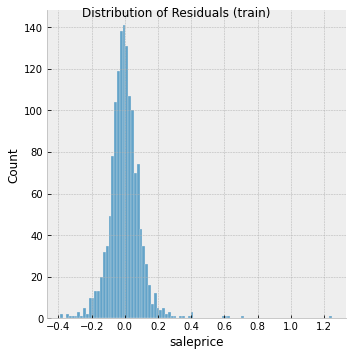

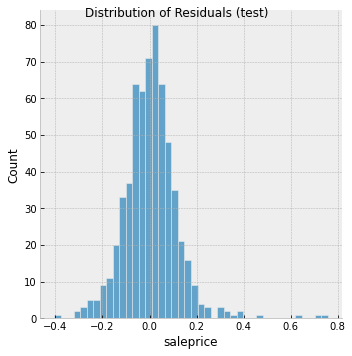

In [92]:
#plot residuals for ridge
residual_plotter(ridge)

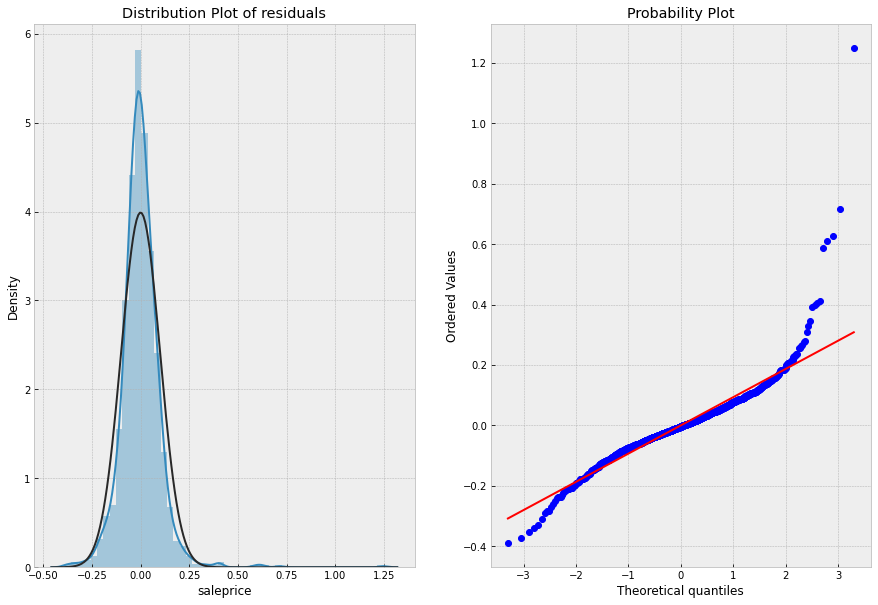

In [93]:
dis_prob_plot_residuals_train(ridge)

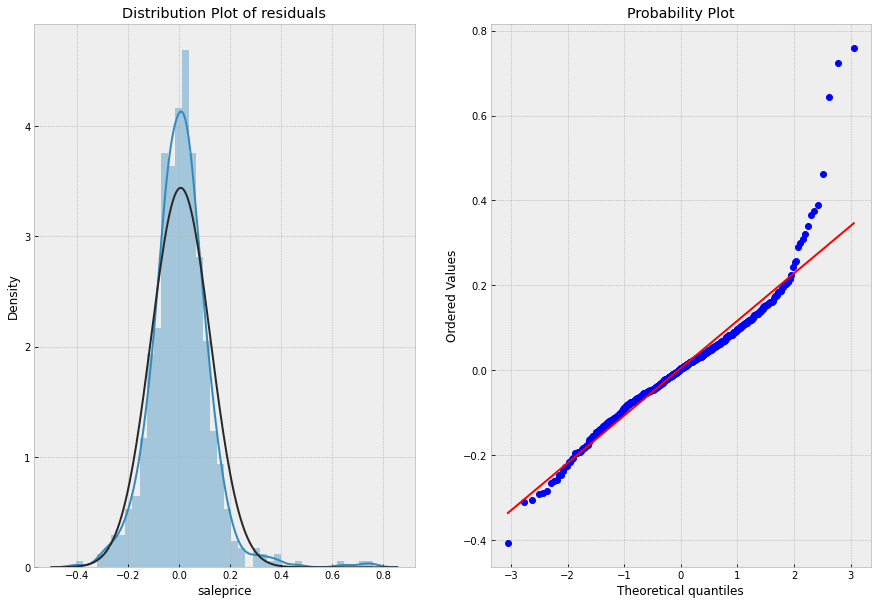

In [94]:
dis_prob_plot_residuals_test(ridge)

##### Observations on the Ridge model.

The ridge model appears to perform better than the LR model.

R^2 performance indicates that the model is able to explain 92% of variance in sale price for the training data and 91.1% of variance in the test data. As the R^2 scores for both the training and test data are close the model is sufficiently generalised and is expected to produce acceptable predictions.

Plotting the residuals against the predicted values of the model we see that with the exception of some outliers, most residuals appear to be randomly spread out along the zero line.

On closer inspection of these outliers it appears that to be a negative relationship between the predicted values and the size of the residuals in these outliers with large positive residuals appearing at the lower end of predicted value. 

This observation can also been seen on the distribution plot and probability plots wehere we see that residuals apprear mostly normally distributed with with the exception of large positive residuals at the top.


##### Hyperparameter tuning for ridge model

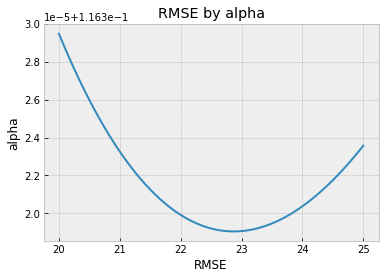

In [95]:
rmse_ridge = [rmse_cv_train(Ridge(alpha = item)) for item in ridge_alphas]
rmse_ridge = pd.Series(rmse_ridge, index=ridge_alphas)
rmse_ridge.plot(title= 'RMSE by alpha')
plt.xlabel('RMSE')
plt.ylabel('alpha');

In [96]:
ridge_alpha = rmse_ridge.idxmin()
print('Best alpha: {}:'.format(ridge_alpha))

Best alpha: 22.87878787878788:


In [97]:
ridge = Ridge(alpha = ridge_alpha)
ridge.fit(X_train, y_train)
print("Ridge RMSE on Training set :", rmse_cv_train(ridge))
print("Ridge RMSE on Test set :", rmse_cv_test(ridge))
print('R2 score on train is {}'.format(r2_score_train(ridge)))
print('R2 score on test is {}'.format(r2_score_test(ridge)))

Ridge RMSE on Training set : 0.11631903914581157
Ridge RMSE on Test set : 0.11551614172924177
R2 score on train is 0.9196748451335471
R2 score on test is 0.91140562519777


Optimising the ridge alpha for RMSLE does result in a small improvement to RMSE while R^2 stays the same.

| Test| Score |
| ----------- | ----------- |
|Test R2 - Original|0.9113352641795854|
|Test R2 - Optimized|0.91140562519777|
|Test RMSLE - Originl|0.11552647964729379|
|Test RMSLE - Optimized|0.11551614172924177|

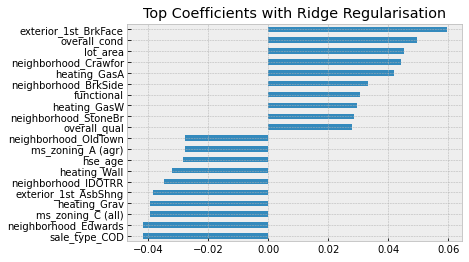

In [98]:
#Ploting the coeficients with the biggest impact on saleprice
ridge_coefs = pd.Series(ridge.coef_, index = X_train.columns)
imp_coefs = pd.concat([ridge_coefs.sort_values().head(10), ridge_coefs.sort_values().tail(10)])
imp_coefs.plot(kind = 'barh')
plt.title('Top Coefficients with Ridge Regularisation')
plt.show()

In [99]:
print('Ridge Picked {} features and eliminated {} features'.format(str(sum(ridge_coefs!= 0)), str(sum(ridge_coefs==0))))

Ridge Picked 530 features and eliminated 9 features


After optimising for RMSLE, ridge model picked 530 features for the regression and dropped 9. Of the features with the highest (absolute) coeficients we can see that there is a mix of factors that affect sale price with various numerical, ordinal and categorical features represented in the chart.

### Lasso Regression

In [100]:
lasso_alphas = np.linspace(0.0004, 0.0008, 100)
lasso = LassoCV(alphas = lasso_alphas, cv = 10,  n_jobs = -1)
lasso.fit(X_train, y_train)

LassoCV(alphas=array([0.0004    , 0.00040404, 0.00040808, 0.00041212, 0.00041616,
       0.0004202 , 0.00042424, 0.00042828, 0.00043232, 0.00043636,
       0.0004404 , 0.00044444, 0.00044848, 0.00045253, 0.00045657,
       0.00046061, 0.00046465, 0.00046869, 0.00047273, 0.00047677,
       0.00048081, 0.00048485, 0.00048889, 0.00049293, 0.00049697,
       0.00050101, 0.00050505, 0.00050909, 0.00051313, 0.00051717,
       0.00...
       0.00066263, 0.00066667, 0.00067071, 0.00067475, 0.00067879,
       0.00068283, 0.00068687, 0.00069091, 0.00069495, 0.00069899,
       0.00070303, 0.00070707, 0.00071111, 0.00071515, 0.00071919,
       0.00072323, 0.00072727, 0.00073131, 0.00073535, 0.00073939,
       0.00074343, 0.00074747, 0.00075152, 0.00075556, 0.0007596 ,
       0.00076364, 0.00076768, 0.00077172, 0.00077576, 0.0007798 ,
       0.00078384, 0.00078788, 0.00079192, 0.00079596, 0.0008    ]),
        cv=10, n_jobs=-1)

In [101]:
print("Lasso RMSE on Training set :", rmse_cv_train(Lasso(alpha = lasso.alpha_)))
print("Lasso RMSE on Test set :", rmse_cv_test(Lasso(alpha = lasso.alpha_)))
print('Lasso R2 score on train is {}'.format(r2_score_train(Lasso(alpha = lasso.alpha_))))
print('Lasso R2 score on test is {}'.format(r2_score_test(Lasso(alpha = lasso.alpha_))))

Lasso RMSE on Training set : 0.11798495973156356
Lasso RMSE on Test set : 0.11562548822143306
Lasso R2 score on train is 0.9171398511502199
Lasso R2 score on test is 0.9115286133180893


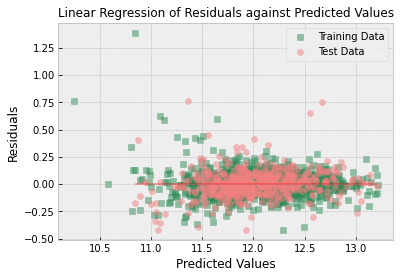

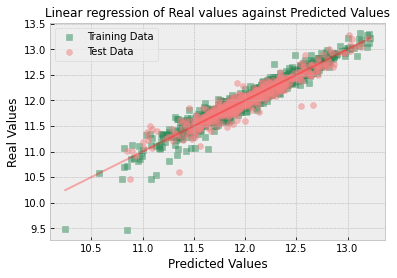

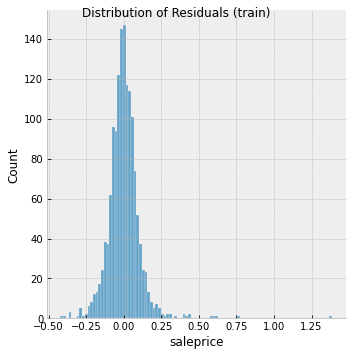

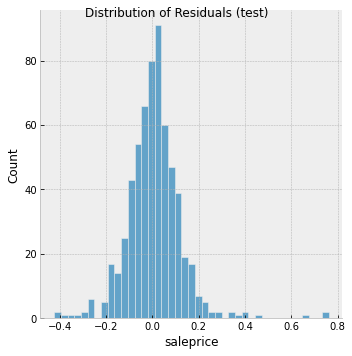

In [102]:
residual_plotter(lasso)

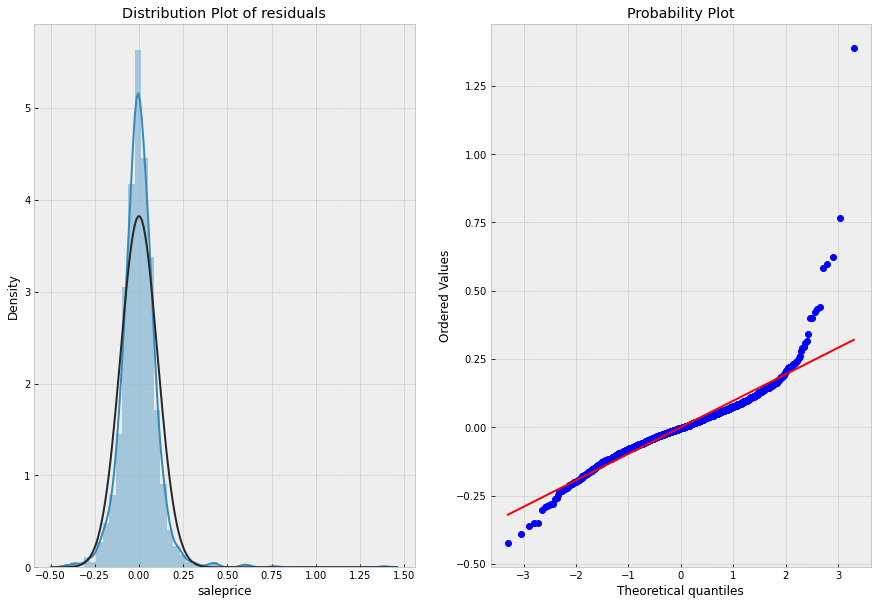

In [103]:
dis_prob_plot_residuals_train(lasso)

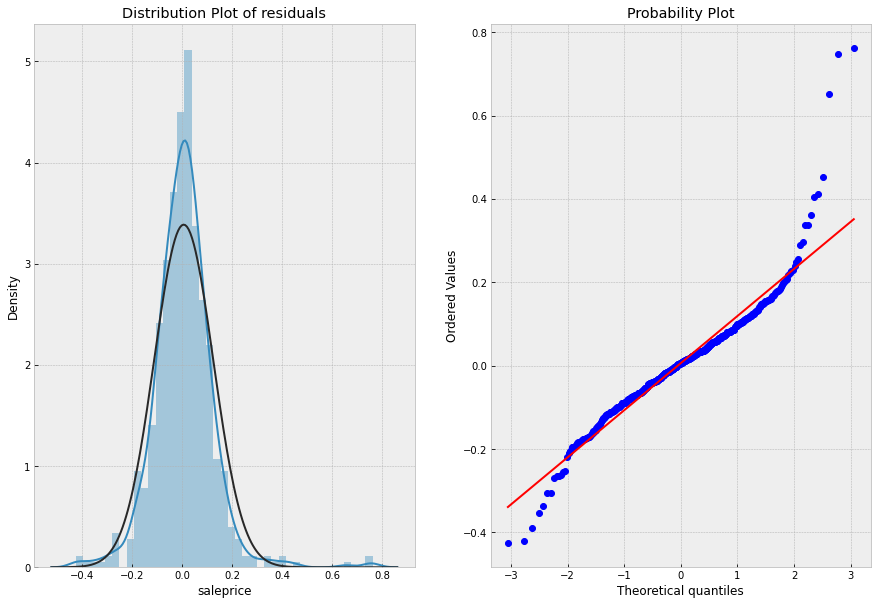

In [104]:
dis_prob_plot_residuals_test(lasso)

##### Observations on Lasso model


R^2 and RMSLE performance using the lasso model is nearly identical to performance using Ridge Regression.

Residuals for the model are similar to the residuals in the ridge model. With majority of the predictions appearing scatted at random when plotted against predicted values and having a normal distribution when plotted on a histogram. However, it is observed that the on the probability plot deviations at both tails are more pronounced indicating a long tail distribution.

Considering the slightly better performance and the more "normal" distribution of errors with the ridge model would have the edge over the lasso model.

##### Hyperparameter tuning for Lasso model

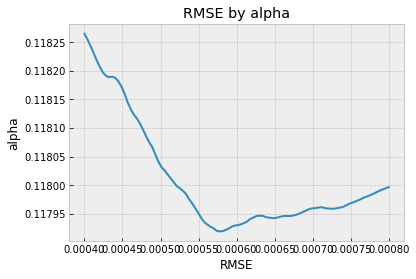

In [105]:
rmse_lasso = [rmse_cv_train(Lasso(alpha = item)) for item in lasso_alphas]
rmse_lasso = pd.Series(rmse_lasso, index=lasso_alphas)
rmse_lasso.plot(title= 'RMSE by alpha')
plt.xlabel('RMSE')
plt.ylabel('alpha');

In [106]:
lasso_alpha = rmse_lasso.idxmin()
print('Best alpha: {}:'.format(lasso_alpha))

Best alpha: 0.0005777777777777778:


In [107]:
lasso = Lasso(alpha = lasso_alpha)
lasso.fit(X_train, y_train)

Lasso(alpha=0.0005777777777777778)

In [108]:
print("Lasso RMSE on Training set :", rmse_cv_train(lasso))
print("Lasso RMSE on Test set :", rmse_cv_test(lasso))
print('R2 score on train is {}'.format(r2_score_train(lasso)))
print('R2 score on test is {}'.format(r2_score_test(lasso)))

Lasso RMSE on Training set : 0.11791920571955408
Lasso RMSE on Test set : 0.11548089778156183
R2 score on train is 0.9171825141181923
R2 score on test is 0.9117886595021275


After tuning hyperparameters for RMSE, we see that both Test R2 and RMSLE improves slightly. Comparing the optimized ridge and lasso models, the lasso model produces a marginally better RMSLE and R2 score. 

Considering that the improvement is marginal and residuals has a less regular distribution in the lasso model, the ridge model would be the better choice.




*Lasso*

| Test| Score |
| ----------- | ----------- |
|Test R2 - Original|0.9115286133180893|
|Test R2 - Optimized|0.9117886595021275|
|Test RMSLE - Originl|0.11562548822143306|
|Test RMSLE - Optimized|0.11548089778156183|


*Ridge*

| Test| Score |
| ----------- | ----------- |
|Test R2 - Original|0.9113352641795854|
|Test R2 - Optimized|0.91140562519777|
|Test RMSLE - Originl|0.11552647964729379|
|Test RMSLE - Optimized|0.11551614172924177|

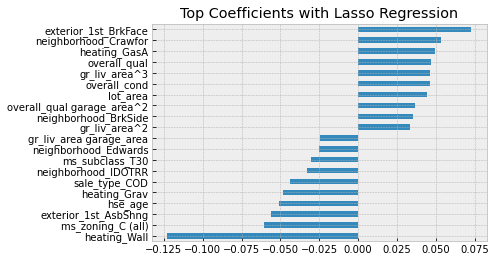

In [109]:
lasso_coefs = pd.Series(lasso.coef_, index = X_train.columns)
imp_coefs = pd.concat([lasso_coefs.sort_values().head(10), lasso_coefs.sort_values().tail(10)])
imp_coefs.plot(kind = 'barh')
plt.title('Top Coefficients with Lasso Regression')
plt.show()

In [110]:
print('Lasso Picked {} features and eliminated {} features'.format(str(sum(lasso_coefs!= 0)), str(sum(lasso_coefs==0))))

Lasso Picked 134 features and eliminated 405 features


The lasso model selected fewer features than the ridge model and as expected with fewer selected features the individual features have generally higher coeficients please refer to the table below for examples. 

|Feature| Coef Value-ridge |Coef Value-lasso|
| ----------- | ----------- | ----------- |
|exterior_1st_brkface|0.06|0.074|
|heating_GasA|0.042|0.049|
|heating_wall|-0.03|-0.125|
|lot_area|0.042|0.048|


We can also see that the polynomial features that we created are also appear more frequently in the lasso model compared to the ridge model.

### ElasticNet

In [111]:
l1_ratios = np.linspace(0, 0.2, 100)
enet_alphas = np.linspace(0.009, 0.02, 100)
enet= ElasticNetCV(l1_ratio = l1_ratios, alphas = enet_alphas, cv = 10, n_jobs = -1)
enet.fit(X_train, y_train)

ElasticNetCV(alphas=array([0.009     , 0.00911111, 0.00922222, 0.00933333, 0.00944444,
       0.00955556, 0.00966667, 0.00977778, 0.00988889, 0.01      ,
       0.01011111, 0.01022222, 0.01033333, 0.01044444, 0.01055556,
       0.01066667, 0.01077778, 0.01088889, 0.011     , 0.01111111,
       0.01122222, 0.01133333, 0.01144444, 0.01155556, 0.01166667,
       0.01177778, 0.01188889, 0.012     , 0.01211111, 0.01222222,
       0.01233333, 0.0...
       0.13131313, 0.13333333, 0.13535354, 0.13737374, 0.13939394,
       0.14141414, 0.14343434, 0.14545455, 0.14747475, 0.14949495,
       0.15151515, 0.15353535, 0.15555556, 0.15757576, 0.15959596,
       0.16161616, 0.16363636, 0.16565657, 0.16767677, 0.16969697,
       0.17171717, 0.17373737, 0.17575758, 0.17777778, 0.17979798,
       0.18181818, 0.18383838, 0.18585859, 0.18787879, 0.18989899,
       0.19191919, 0.19393939, 0.1959596 , 0.1979798 , 0.2       ]),
             n_jobs=-1)

In [112]:
print("Ridge RMSE on Training set :", rmse_cv_train(ElasticNet(l1_ratio = enet.l1_ratio_, alpha = enet.alpha_)))
print("Ridge RMSE on Test set :", rmse_cv_test(ElasticNet(l1_ratio = enet.l1_ratio_, alpha = enet.alpha_)))
print('R2 score on train is {}'.format(r2_score_train(ElasticNet(l1_ratio = enet.l1_ratio_, alpha = enet.alpha_))))
print('R2 score on test is {}'.format(r2_score_test(ElasticNet(l1_ratio = enet.l1_ratio_, alpha = enet.alpha_))))

Ridge RMSE on Training set : 0.11633629880717718
Ridge RMSE on Test set : 0.11608479738486979
R2 score on train is 0.9196422693241046
R2 score on test is 0.9099872344660259


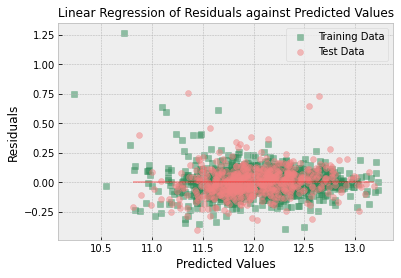

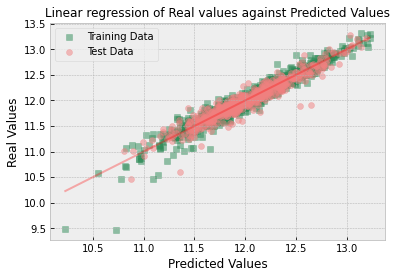

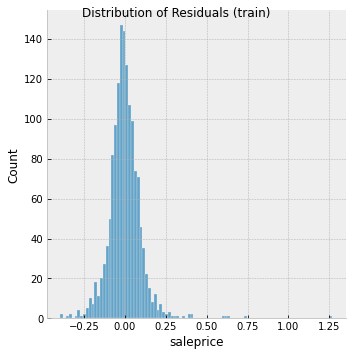

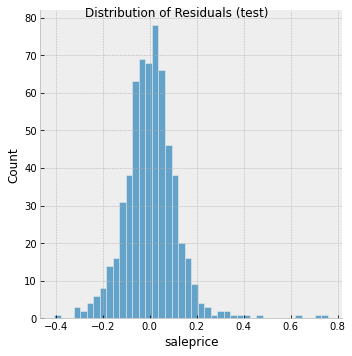

In [113]:
residual_plotter(enet)

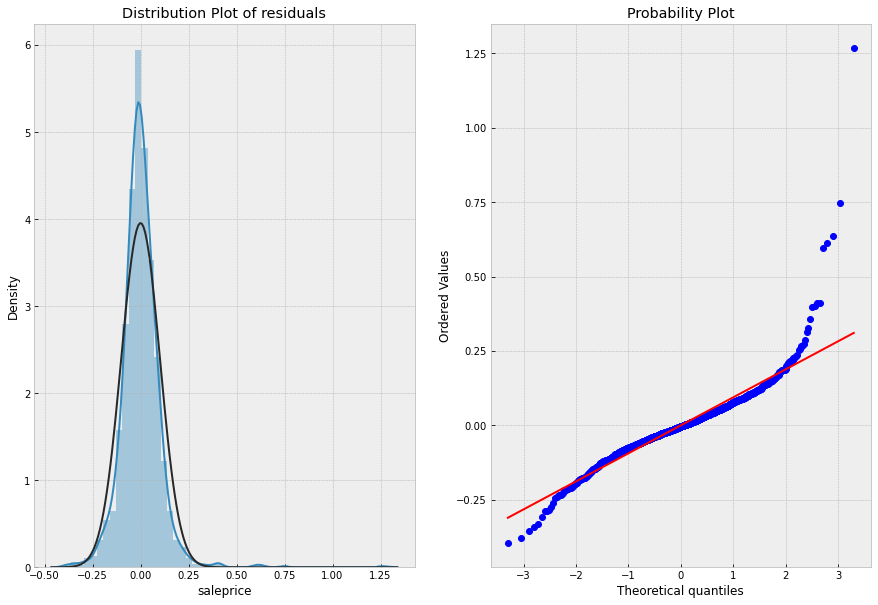

In [114]:
dis_prob_plot_residuals_train(enet)

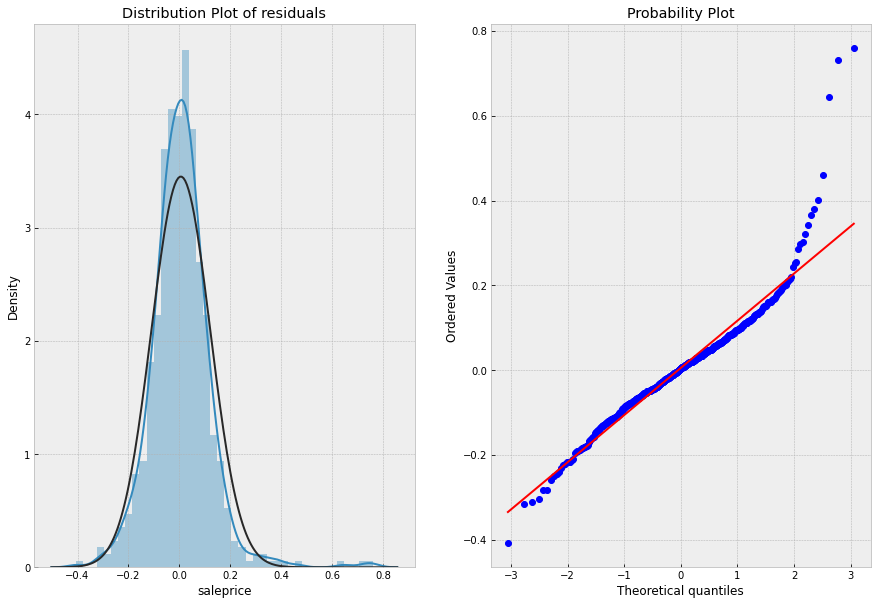

In [115]:
dis_prob_plot_residuals_test(enet)

##### Observations on the ElasticNet model.

The ElasticNet model appears to perform better than the LR model.

R^2 performance indicates that the model is able to explain 91.9% of variance in sale price for the training data and 90.9% of variance in the test data. As the R^2 scores for both the training and test data are close the model is sufficiently generalised and is expected to produce acceptable predictions. R^2 performance is similar to performance on the ridge model.


Plotting the residuals produces almost similar scatter, distribution and probability to the ridge model.

Similar to the ridge model there appears to be several outliers on the low end of predicted values and high positive residuals indicating that the model has a long right tail


##### Hyperparameter tuning for Enet model

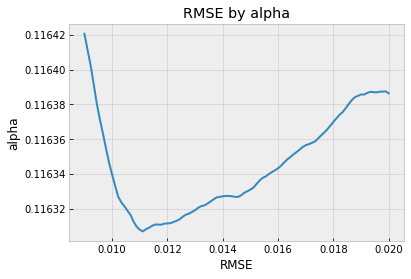

In [116]:
#plotting RMSLE by alpha
rmse_enet = [rmse_cv_train(ElasticNet(alpha = item, l1_ratio = enet.l1_ratio_)) for item in enet_alphas]
rmse_enet = pd.Series(rmse_enet, index=enet_alphas)
rmse_enet.plot(title= 'RMSE by alpha')
plt.xlabel('RMSE')
plt.ylabel('alpha');

In [117]:
#determining the best alpha for RMSLE
enet_alpha = rmse_enet.idxmin()
print('Best alpha: {}'.format(enet_alpha))

Best alpha: 0.01111111111111111


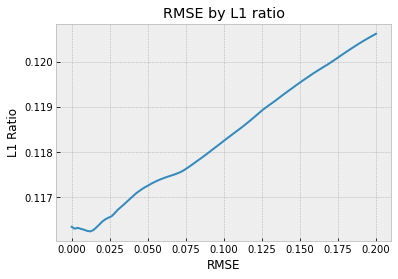

In [118]:
#Plotting best L1 ratio
rmse_enet = [rmse_cv_train(ElasticNet(l1_ratio = ratio, alpha = enet_alpha)) for ratio in l1_ratios]
rmse_enet = pd.Series(rmse_enet, index=l1_ratios)
rmse_enet.plot(title= 'RMSE by L1 ratio')
plt.xlabel('RMSE')
plt.ylabel('L1 Ratio');

In [119]:
#determining and selecting best L1 Ratio
enet_l1_ratio = rmse_enet.idxmin()
print('Best L1: {}:'.format(enet_l1_ratio))

Best L1: 0.012121212121212121:


In [120]:
enet= ElasticNet(l1_ratio = enet_l1_ratio, alpha = enet_alpha)
enet.fit(X_train, y_train)

ElasticNet(alpha=0.01111111111111111, l1_ratio=0.012121212121212121)

In [121]:
print("enet RMSE on Training set :", rmse_cv_train(enet))
print("enet RMSE on Test set :", rmse_cv_test(enet))
print('R2 score on train is {}'.format(r2_score_train(enet)))
print('R2 score on test is {}'.format(r2_score_test(enet)))

enet RMSE on Training set : 0.11624674467133103
enet RMSE on Test set : 0.11559933262926461
R2 score on train is 0.9196874303207048
R2 score on test is 0.9108953797845494


Comparing the performance of all models post optimization, we see that there is a very small difference R^2 and RMSE performance in the 3 models with a max difference of 0.07% in R^2 scores and 0.00003 in RMSLE, with the lasso model performing the best of the 3 models, followed by the ElasticNet model.

Although Lasso produces the smallest RMSLE, considering the more normal distribution of residuals in the enet model, the enet model is preferred over lasso.

*Enet*

| Test| Score |
| ----------- | ----------- |
|Test R2 - Original|0.9094279131180644|
|Test R2 - Optimized|0.911064504914556|
|Test RMSLE - Originl|0.11641623889177506|
|Test RMSLE - Optimized|0.11550905340337854|


*Lasso*

| Test| Score |
| ----------- | ----------- |
|Test R2 - Original|0.9115286133180893|
|Test R2 - Optimized|0.9117886595021275|
|Test RMSLE - Originl|0.11562548822143306|
|Test RMSLE - Optimized|0.11548089778156183|


*Ridge*

| Test| Score |
| ----------- | ----------- |
|Test R2 - Original|0.9113352641795854|
|Test R2 - Optimized|0.91140562519777|
|Test RMSLE - Originl|0.11552647964729379|
|Test RMSLE - Optimized|0.11551614172924177|

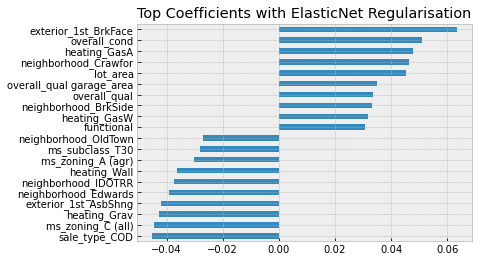

In [122]:
enet_coefs = pd.Series(enet.coef_, index = X_train.columns)
imp_coefs = pd.concat([enet_coefs.sort_values().head(10), enet_coefs.sort_values().tail(10)])
imp_coefs.plot(kind = 'barh')
plt.title('Top Coefficients with ElasticNet Regularisation')
plt.show()

In [123]:
print('ElasticNet Picked {} features and eliminated {} features'.format(str(sum(enet_coefs!= 0)), str(sum(enet_coefs==0))))

ElasticNet Picked 311 features and eliminated 228 features


##### Thoughts on coefficients
**HF:** Regression coefficients general describes the size and direction of the relationship between the independent variable (the features) and target variable (sales price).

eatures such as overall_condition, lot_area and overall_qual had strong positive coeficients as well indicating that houses with higher quality, condition and size tend to sell at a premium compared to smaller houses in poor condition.

We also note that different neighborhoods and zoning types had different regression coeficients. Houses in less desierable neighborhoods/zoning types that had negative regression coeficients should be avoided as they generally bring down sale price. 

#### Highlighted  and interpreting coefficients of features selected by ElasticNet Model

In [124]:
# resurfacing the features that were log transformed.
imp_coefs = pd.DataFrame(data = imp_coefs)
skewed_features

['lot_frontage',
 'lot_area',
 'mas_vnr_area',
 'bsmtfin_sf_1',
 'bsmtfin_sf_2',
 'bsmt_unf_sf',
 '1st_flr_sf',
 '2nd_flr_sf',
 'low_qual_fin_sf',
 'gr_liv_area',
 'bsmt_full_bath',
 'bsmt_half_bath',
 'half_bath',
 'kitchen_abvgr',
 'totrms_abvgrd',
 'fireplaces',
 'garage_yr_blt',
 'wood_deck_sf',
 'open_porch_sf',
 'enclosed_porch',
 '3ssn_porch',
 'screen_porch',
 'pool_area',
 'misc_val',
 'saleprice',
 'bsmt_fin_area',
 'hse_sf']

In [125]:
# covering coef data into a df
imp_coefs_df = pd.DataFrame(data = imp_coefs)
imp_coefs_df

,0
sale_type_COD,-0.045068
ms_zoning_C (all),-0.044402
heating_Grav,-0.042620
exterior_1st_AsbShng,-0.041949
neighborhood_Edwards,-0.039134
neighborhood_IDOTRR,-0.037273
heating_Wall,-0.036248
ms_zoning_A (agr),-0.030368
ms_subclass_T30,-0.028152
neighborhood_OldTown,-0.027146


In [126]:
# formula to interpret of effect on changing various features that were log transformed
for feature in imp_coefs.index:
    if feature in skewed_features:
        print('A 1% increase in {} will result in {}% increase in saleprice'.format(feature, round((1.01**(imp_coefs.loc[feature, 0])-1)*100,2)))
        
              


A 1% increase in lot_area will result in 0.05% increase in saleprice


In [127]:
# formula to interpret of effect on changing various features that were not log transformed
for feature in imp_coefs.index:
    if feature not in skewed_features:
        print('Changing {} will result in {}% change in saleprice'.format(feature, round((np.exp(imp_coefs.loc[feature, 0])-1)*100,3)))

Changing sale_type_COD will result in -4.407% change in saleprice
Changing ms_zoning_C (all) will result in -4.343% change in saleprice
Changing heating_Grav will result in -4.172% change in saleprice
Changing exterior_1st_AsbShng will result in -4.108% change in saleprice
Changing neighborhood_Edwards will result in -3.838% change in saleprice
Changing neighborhood_IDOTRR will result in -3.659% change in saleprice
Changing heating_Wall will result in -3.56% change in saleprice
Changing ms_zoning_A (agr) will result in -2.991% change in saleprice
Changing ms_subclass_T30 will result in -2.776% change in saleprice
Changing neighborhood_OldTown will result in -2.678% change in saleprice
Changing functional will result in 3.108% change in saleprice
Changing heating_GasW will result in 3.216% change in saleprice
Changing neighborhood_BrkSide will result in 3.366% change in saleprice
Changing overall_qual will result in 3.406% change in saleprice
Changing overall_qual garage_area will resul

## Conclusions and Recommendations 

We set out to create a linear regression model that could predict the sale prices of properties with the following uses in mind:

1) Serve as a comparison against bids submitted by home sellers to determined if bids received are over/under valuation, 
2) determine how changes to various features of a house affects the sale price so that capital can be directed towards repairs/ renovations that generate the largest change in salesprice; and 
3) ascertain the expected sale price of a refurbised and relisted property.

We will evaluate the performance of the model and our recommendations based on the results of the model in relation to each goal.

##### One

Our chosen model model has a R^2 score of 91.1% and a RMSLE score of 0.11551. Based on these matrics we expect that the model is robust and is able to account for ~91% of the variance in sale prices and that our predictions are within $20,000 of the actual sale price. 

Reviewing the residuals of this model also revealed that most errors can be attributed to our model overestimating sale prices of properties that were sold for ~$13,000 - 15,000. Considering that such low sale prices are rare in the dataset we expect the model to make predictions with smaller errors for a large majoriy of future bids and will provide good basis to determine the profitablity of bids received.


##### Two

Our second goal was to determine how individual features would affect the sale price. Of the 540 features (79 original + created features + polynomial features + dummies) that we fed into the ElasticNet Model the model eliminated 226 features and by sorting the remaining features we can see that there are various features with relatively strong coeficients that we can act upon.

Broadly speaking we observe that there is a mix of features describing quality, condition, living area, neighbourhood/zoning and aesthetic features have a notable impact on housing prices.

We can separate the features into 2 buckets and employ different strategies to mitigate the effect of negative variables while leveraging on features that have a positive impact to increase potential sale price. 

For features that we can be altered during the renovation process, we could divert captital to features that had strong positive coeficient with sale price. For example, changing the exterior of a house to brick ('exterior_1st_BrkFace', coef of 0.06) is expected to increase sale price by 6% (exp(0.06)-1) or swapping out heat_grav (gravity heating) is expected to increase prices by 3.9\%. Based on our findings we have. we propose the creation of a companion model that uses info on labor and material cost to predict the expected cost of various changes and using the the two models together to determine the profitablity of renovations and repairs.

For features that we cannot change like neighborhood or zoning types we could avoid purchasing houses or make smaller offers for homes in less desierable areas, and make higher offers in areas that have a positive coeficient with saleprice. For example, a home in Edwards has a coeficient of -0.03 and is expected to sell for 3% lower by avoiding houses in Edwards we can reserve our funds for projects with better projected returns.


##### Three

Similar to point 1 we expect our model to be able to accurately sale price given its features. As our model has an error of 20,000, We propose to mitigate this by starting our listings at a premium of 20,000 above our model predictions, allowing us to maintain margins in the event that the model makes an under-estimate.


### Possible Imoprvements to the Model

The data was was collected between 2006 and 2010 and in the last 11 years external factors that we have not accouted for could affect our model predictions. For example, the effect of black swan events like covid in 2019 to 2021 has resulting in large increases of 11.5% in home prices between Dec 2020 and Dec 2021 in comparison to the relatively muted gain 4% annual gain between 2010 to [2019](#https://www.cnbc.com/2021/09/03/asia-pacific-property-bidding-wars-cash-offers-drive-up-home-prices.html) 

In addition, trends in architectural preferences can fluctuate with time and our model will need constantly updated to ensure the coeficient of regression for various features truely reflect current preferences.

### [For Kaggle] Output to CSV

In [128]:
main_model = enet

In [129]:
submission_features = [column for column in test.columns if column != 'saleprice']
submission_features.remove('pid')
submission_x = test[submission_features]
main_model.fit(X_train, y_train)

ElasticNet(alpha=0.01111111111111111, l1_ratio=0.012121212121212121)

In [130]:
submission_predictions = main_model.predict(submission_x)
upload_predictions = np.exp(submission_predictions)-1
output = pd.DataFrame({'Id': test.index, 'saleprice': upload_predictions})
output.to_csv('../submissioncsv/submission.csv', index = False)